In [12]:
# Import libraries

import os
import pickle
import gc

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import wilcoxon
from scipy.stats import pearsonr
from processing_session_trajectory import *


In [19]:
path_to_data_folder = '/home/david/MyLocalData/Maud/' # Maud work computer
# path_to_data_folder = 'C:/Users/mauds/Documents' # Maud personal computer
# path_to_data_folder = 'D:/WORKING_FROM_HOME/Données_Gq_UL' # Maud hard disk

pattern_of_MOU_Folders = os.path.join(path_to_data_folder, "MOU*")

mice_list: list[str] = ["MOU3867","MOU4551","MOU4623","MOU4562","MOU4560","MOU4623","MOU4624","MOU4552","MOU4563","MOU4561","MOU4692","MOU4694","MOU4695","MOU4696","MOU4698","MOU4703","MOU4704","MOU4175","MOU4185"]
# mice_list: list[str] = ["MOU4908","MOU4909","MOU4910","MOU4924","MOU4926","MOU4930","MOU4932"]
UL_Gq_D1_DLS: list[str] = ["MOU4623","MOU4551","MOU4185"]
UL_Gq_D2_DLS: list[str] = ["MOU4562","MOU4560","MOU4696","MOU4694","MOU4175"]
UL_Gq_D1_DMS: list[str] = ["MOU4624","MOU4552","MOU4703","MOU4704","MOU3867"]
UL_Gq_D2_DMS: list[str] = ["MOU4563","MOU4561","MOU4695","MOU4698","MOU4692"]
# BL_Gq_D1_DMS: list[str] = ["MOU4908","MOU4909","MOU4910"]
# BL_Gq_D2_DMS: list[str] = ["MOU4924","MOU4926","MOU4930","MOU4932"]

session_list = {}
for mouse in mice_list:
    mouse_folder = os.path.join(path_to_data_folder,mouse)
    session_list[mouse] = sorted([name for name in os.listdir(mouse_folder)
                           if os.path.isdir(os.path.join(mouse_folder, name))
                           and name.startswith('MOU')])
    nb_sessions = len(session_list[mouse])
    # print(f'Hello, I\'m {mouse}! I have foraged for {nb_sessions} sessions')


In [20]:
# Fonction pour tronquer une colormap
def truncate_colormap(cmap, min_val=0.2, max_val=1.0, n=256):
    """Tronquer une colormap existante pour éviter les couleurs claires."""
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        f"truncated({cmap.name},{min_val:.2f},{max_val:.2f})",
        cmap(np.linspace(min_val, max_val, n))
    )
    return new_cmap

# Colormaps originales
original_gnbu = plt.cm.GnBu
original_ylorbr = plt.cm.YlOrBr

# Colormaps tronquées
truncated_gnbu = truncate_colormap(original_gnbu, min_val=0.3)
truncated_ylorbr = truncate_colormap(original_ylorbr, min_val=0.3)

In [56]:
# Dictionnaries of groups, sessions indices, colors...

groups = {
    "D1 DLS": UL_Gq_D1_DLS,
    "D2 DLS": UL_Gq_D2_DLS,
    "D1 DMS": UL_Gq_D1_DMS,
    "D2 DMS": UL_Gq_D2_DMS,
    # "All":mice_list
    # "D1 dS": UL_Gq_D1_dS,
    # "D2 dS": UL_Gq_D2_dS
}

# Définir les indices de sessions
session_indices = {
    "control_first": 16,
    "CNO_first": 20,
    "control_second": 26,
    "CNO_second": 30,
    "control_third": 40,
    "CNO_third": 42
}

# Paire de sessions à analyser
session_pairs = [
    ("control_first", "CNO_first"),
    ("control_second", "CNO_second"),
    ("control_third","CNO_third")
]

groups_D1_D2 = {
    "D1":UL_Gq_D1_DLS+UL_Gq_D1_DMS,
    "D2":UL_Gq_D2_DLS+UL_Gq_D2_DMS,
    # "All":mice_list
}

# BL_groups = {
#     "D1":BL_Gq_D1_DMS,
#     "D2":BL_Gq_D2_DMS,
#     "All": BL_Gq_D1_DMS + BL_Gq_D2_DMS
# }

colormaps = {
    "D1 DLS": "Greens",
    "D2 DLS": "Oranges",
    "D1 DMS": "Blues",
    "D2 DMS": "RdPu",
    "D1 dS": "Purples",
    "D2 dS": "OrRd",
    "D1": truncated_gnbu,
    "D2": truncated_ylorbr,
    "All": "viridis"
}

In [22]:
# Data extraction from pickle for further plots

gc.collect()

positions_cm_dict = {}
X_positions_dict = {}
Y_positions_dict = {}
total_distances = {}
average_speeds = {}
distances_dict = {}
speeds_dict = {}
angular_speeds_dict = {}
all_epochs_dict = {}
traject_time_dict = {}
run_around_tower_results_dict = {}
runs_around_tower_dict = {}
trapezes_coordinates_dict = {}
towers_coordinates_dict = {}
runs_between_towers_dict = {}
exploratory_runs_dict = {}
time_border_dict = {}
time_interior_dict = {}
time_trapeze_dict = {}
distance_border_dict = {}
distance_interior_dict = {}
distance_trapeze_dict = {}
ratio_time_trapeze_over_border = {}
ratio_distance_trapeze_over_border = {}
time_trapeze_minus_border = {}
distance_trapeze_minus_border = {}


# Boucle pour traiter chaque souris
for mouse in mice_list:
    
    # Initialiser les sous-dictionnaires pour chaque souris
    positions_cm_dict[mouse] = {}
    X_positions_dict[mouse] = {}
    Y_positions_dict[mouse] = {}
    total_distances[mouse] = {}
    average_speeds[mouse] = {}
    distances_dict[mouse] = {}
    speeds_dict[mouse] = {}
    angular_speeds_dict[mouse] = {}
    all_epochs_dict[mouse] = {}
    traject_time_dict[mouse] = {}
    run_around_tower_results_dict[mouse] = {}
    runs_around_tower_dict[mouse] = {}
    trapezes_coordinates_dict[mouse] = {}
    towers_coordinates_dict[mouse] = {}
    runs_between_towers_dict[mouse] = {}
    exploratory_runs_dict[mouse] = {}
    time_border_dict[mouse] = {}
    time_interior_dict[mouse] = {}
    time_trapeze_dict[mouse] = {}
    distance_border_dict[mouse] = {}
    distance_interior_dict[mouse] = {}
    distance_trapeze_dict[mouse] = {}
    ratio_time_trapeze_over_border[mouse] = {}
    ratio_distance_trapeze_over_border[mouse] = {}
    time_trapeze_minus_border[mouse] = {}
    distance_trapeze_minus_border[mouse] = {}

    for session_index, session_name in enumerate(session_list[mouse]):
        
        output_pickle_filepath = os.path.join(path_to_data_folder, mouse, session_name, f"{session_name}_basic_processing_output.pickle")

        if not os.path.exists(output_pickle_filepath):
            print(f"Erreur : le fichier {output_pickle_filepath} n'existe pas.")
            continue
        elif os.path.getsize(output_pickle_filepath) == 0:
            print(f"Erreur : le fichier {output_pickle_filepath} est vide.")
            continue

        # Chargement des données depuis le pickle
        try:
            with open(output_pickle_filepath, 'rb') as f:
                data = pickle.load(f)
        except EOFError:
            print(f"Erreur de lecture : le fichier {output_pickle_filepath} semble être corrompu.")
            continue

        # Extraction des données
        positions_cm = data['positions']
        X_positions_cm = data['positions'][0]
        Y_positions_cm = data['positions'][1]
        average_speed = data['average_speed']
        distances = data['distances']
        speeds = data['speeds']
        angular_speeds = data['angular_speeds']
        all_epochs = data['all_epochs']
        traject_time = data['timeofframes']
        run_around_tower_results = data['run_around_tower_sessionresult']
        runs_around_tower = all_epochs['run_around_tower']
        runs_between_towers = all_epochs['run_between_towers']
        exploratory_runs = all_epochs['exploratory_run']
        trapezes_coordinates = data['all_trapezes_coordinates_cm']
        towers_coordinates = data['towers_coordinates_cm']
        time_border = data['time_in_zones']['border']
        time_interior = data['time_in_zones']['interior']
        time_trapeze = data['time_in_zones']['trapeze']
        distance_border = data['distance_in_zones']['border']
        distance_interior = data['distance_in_zones']['interior']
        distance_trapeze = data['distance_in_zones']['trapeze']

        # Calcul de la distance totale en mètres
        total_distance = np.sum(distances) / 100

        # Stockage dans les dictionnaires complets en utilisant l'index de session
        positions_cm_dict[mouse][session_index] = positions_cm
        X_positions_dict[mouse][session_index] = X_positions_cm
        Y_positions_dict[mouse][session_index] = Y_positions_cm
        total_distances[mouse][session_index] = total_distance
        average_speeds[mouse][session_index] = average_speed
        distances_dict[mouse][session_index] = distances
        speeds_dict[mouse][session_index] = speeds
        angular_speeds_dict[mouse][session_index] = angular_speeds
        all_epochs_dict[mouse][session_index] = all_epochs
        traject_time_dict[mouse][session_index] = traject_time
        run_around_tower_results_dict[mouse][session_index] = run_around_tower_results
        runs_around_tower_dict[mouse][session_index] = runs_around_tower
        trapezes_coordinates_dict[mouse][session_index] = trapezes_coordinates
        towers_coordinates_dict[mouse][session_index] = towers_coordinates
        runs_between_towers_dict[mouse][session_index] = runs_between_towers
        exploratory_runs_dict[mouse][session_index] = exploratory_runs
        time_border_dict[mouse][session_index] = time_border
        time_interior_dict[mouse][session_index] = time_interior
        time_trapeze_dict[mouse][session_index] = time_trapeze
        distance_border_dict[mouse][session_index] = distance_border
        distance_interior_dict[mouse][session_index] = distance_interior
        distance_trapeze_dict[mouse][session_index] = distance_trapeze

        ratio_time_trapeze_over_border[mouse][session_index] = time_trapeze/time_border
        ratio_distance_trapeze_over_border[mouse][session_index] = distance_trapeze/distance_border
        time_trapeze_minus_border[mouse][session_index] = time_trapeze - time_border
        distance_trapeze_minus_border[mouse][session_index] = distance_trapeze - distance_border

/tmp/ipykernel_23597/897130577.py:133: RuntimeWarning: divide by zero encountered in double_scalars
  ratio_time_trapeze_over_border[mouse][session_index] = time_trapeze/time_border
/tmp/ipykernel_23597/897130577.py:134: RuntimeWarning: divide by zero encountered in double_scalars
  ratio_distance_trapeze_over_border[mouse][session_index] = distance_trapeze/distance_border


In [23]:
# Dictionnary to store rewarded direction per session

rewarded_direction_per_session = {}

# Parcourir chaque souris dans la liste des souris
for mouse in mice_list:
    rewarded_direction_per_session[mouse] = {}  # Initialiser le sous-dictionnaire pour chaque souris
    
    # Parcourir chaque session de cette souris
    for session_index, session_name in enumerate(session_list[mouse]):
        # Construire le chemin d'accès au fichier CSV
        csv_file_path = os.path.join(path_to_data_folder, mouse, session_name, f"{session_name}_sessionparam.csv")
        
        # Lire le fichier CSV pour obtenir la colonne potentialRewardedDirections
        try:
            session_data = pd.read_csv(csv_file_path)
            rewarded_directions = session_data["potentialRewardedDirections"].iloc[0]  # Supposant que c'est dans la première ligne
            
            # Décoder la direction récompensée
            if rewarded_directions == "[90]":
                direction = "CCW"
            elif rewarded_directions == "[270]":
                direction = "CW"
            else:
                direction = "both"
            
            # Ajouter cette information dans le dictionnaire
            rewarded_direction_per_session[mouse][session_index] = direction

        except FileNotFoundError:
            print(f"Fichier {csv_file_path} non trouvé.")
        except Exception as e:
            print(f"Erreur lors de la lecture de {csv_file_path}: {e}")

In [24]:
# Dictionnaries to store good and bad turns

good_turns_dict = {}
bad_turns_dict = {}

for mouse in mice_list:

    good_turns_dict[mouse] = {}
    bad_turns_dict[mouse] = {}
    
    for session_index, session_name in enumerate(session_list[mouse]):

        runs_around_tower = runs_around_tower_dict[mouse][session_index]
        rewarding_direction = rewarded_direction_per_session[mouse][session_index]

        good_turns = []
        bad_turns = []

        for run in runs_around_tower:
            if run[3]['direction'] == rewarding_direction:
                good_turns.append(run)
            else:
                bad_turns.append(run)

        good_turns_dict[mouse][session_index] = good_turns
        bad_turns_dict[mouse][session_index] = bad_turns

# print(good_turns_dict['MOU4562'][19])

In [25]:
# Dictionnaries of rewarded/unrewarded turns and their mean speeds
# Big problem here, to check

rewarded_QT_dict = {}
unrewarded_QT_dict = {}
med_rew_meanspeeds = {}
med_unrew_meanspeeds = {}



for mouse in mice_list:

    rewarded_QT_dict[mouse]={}
    unrewarded_QT_dict[mouse] = {}
    med_rew_meanspeeds[mouse] = {}
    med_unrew_meanspeeds[mouse] = {}

    for session_index, session_name in enumerate(session_list[mouse]):

        runs_around_tower = runs_around_tower_dict[mouse][session_index]
        rewarded_QT = []
        unrewarded_QT = []
        meanspeed_rewarded_QT = []
        meanspeed_unrewarded_QT = []

        for run in runs_around_tower:

            start_index, end_index = run[0][0], run[0][1]

            if run[3]['Rewarded'] == True:

                rewarded_QT.append(run)
                run_duration_rew_QT = traject_time_dict[mouse][session_index][end_index] - traject_time_dict[mouse][session_index][start_index]
                distance_ran_rew_QT = np.sum(distances_dict[mouse][session_index][start_index:end_index])
                meanspeed_rewarded_QT.append(distance_ran_rew_QT / run_duration_rew_QT)
                # meanspeed_rewarded_QT.append(run[4]['epoch_meanspeed'])

            else:
                unrewarded_QT.append(run)
                run_duration_unrew_QT = traject_time_dict[mouse][session_index][end_index] - traject_time_dict[mouse][session_index][start_index]
                distance_ran_unrew_QT = np.sum(distances_dict[mouse][session_index][start_index:end_index])
                meanspeed_unrewarded_QT.append(distance_ran_unrew_QT / run_duration_unrew_QT)
                # meanspeed_unrewarded_QT.append(run[4]['epoch_meanspeed'])
    
        rewarded_QT_dict[mouse][session_index] = rewarded_QT
        unrewarded_QT_dict[mouse][session_index] = unrewarded_QT

        med_rew_meanspeeds[mouse][session_index] = round(np.median(meanspeed_rewarded_QT),2) if meanspeed_rewarded_QT else None
        med_unrew_meanspeeds[mouse][session_index] = round(np.median(meanspeed_unrewarded_QT),2) if meanspeed_unrewarded_QT else None

        if med_unrew_meanspeeds[mouse][session_index] is None:
            print(f"Attention, valeur None pour {mouse} et session index {session_index}")

        # print(med_unrew_meanspeeds[mouse][session_index])

Attention, valeur None pour MOU3867 et session index 2
Attention, valeur None pour MOU3867 et session index 3
Attention, valeur None pour MOU4551 et session index 2
Attention, valeur None pour MOU4551 et session index 3
Attention, valeur None pour MOU4623 et session index 2
Attention, valeur None pour MOU4623 et session index 3
Attention, valeur None pour MOU4562 et session index 1
Attention, valeur None pour MOU4562 et session index 2
Attention, valeur None pour MOU4562 et session index 3
Attention, valeur None pour MOU4560 et session index 0
Attention, valeur None pour MOU4560 et session index 2
Attention, valeur None pour MOU4560 et session index 3
Attention, valeur None pour MOU4623 et session index 2
Attention, valeur None pour MOU4623 et session index 3
Attention, valeur None pour MOU4624 et session index 0
Attention, valeur None pour MOU4624 et session index 2
Attention, valeur None pour MOU4624 et session index 3
Attention, valeur None pour MOU4552 et session index 1
Attention,

In [26]:
# Store necessary datas in dictionnary for next plots

total_QT_dict = {}
total_QT_rewarded_dict = {}
total_QT_unrewarded_dict = {}
total_CW_dict = {}
total_CCW_dict = {}
ratio_CW_CCW_dict = {}
percentage_rewarded_dict = {}

total_time_QT_dict = {}
total_distance_QT_dict = {}
meanspeed_QT_dict = {}
maxspeed_QT_dict = {}

total_time_BT_dict = {}
total_distance_BT_dict = {}
meanspeed_BT_dict = {}

for mouse in mice_list:
    
    total_QT_dict[mouse] = {}
    total_QT_rewarded_dict[mouse] = {}
    total_QT_unrewarded_dict[mouse] = {}
    total_CW_dict[mouse] = {}
    total_CCW_dict[mouse] = {}
    ratio_CW_CCW_dict[mouse] = {}
    percentage_rewarded_dict[mouse] = {}

    total_time_QT_dict[mouse] = {}
    total_distance_QT_dict[mouse] = {}
    meanspeed_QT_dict[mouse] = {}
    maxspeed_QT_dict[mouse] = {}

    total_time_BT_dict[mouse] = {}
    total_distance_BT_dict[mouse] = {}
    meanspeed_BT_dict[mouse] = {}

    for session_index, session_name in enumerate(session_list[mouse]):

        total_CW_rewarded = run_around_tower_results_dict[mouse][session_index]['All']['rewarded_CW']
        total_CCW_rewarded = run_around_tower_results_dict[mouse][session_index]['All']['rewarded_CCW']
        total_CW = run_around_tower_results_dict[mouse][session_index]['All']['total_CW']
        total_CCW = run_around_tower_results_dict[mouse][session_index]['All']['total_CCW']

        total_time_QT = 0
        total_distance_QT = 0
        meanspeed_QT = []
        maxspeed_QT = []

        total_time_BT = 0
        total_distance_BT = 0
        meanspeed_BT = []
        
        for run in runs_around_tower_dict[mouse][session_index]:
            start_index, end_index = run[0][0], run[0][1]
            run_duration_QT = traject_time_dict[mouse][session_index][end_index] - traject_time_dict[mouse][session_index][start_index]
            distance_ran_QT = np.sum(distances_dict[mouse][session_index][start_index:end_index])
            meanspeed_QT.append(distance_ran_QT / run_duration_QT)

        for run in runs_between_towers_dict[mouse][session_index]:
            start_index, end_index = run[0][0], run[0][1]
            run_duration_BT = traject_time_dict[mouse][session_index][end_index] - traject_time_dict[mouse][session_index][start_index]
            distance_ran_BT = np.sum(distances_dict[mouse][session_index][start_index:end_index])
            meanspeed_BT.append(distance_ran_BT / run_duration_BT)
    
        total_QT = total_CW + total_CCW
        total_QT_rewarded = total_CW_rewarded + total_CCW_rewarded
        total_QT_unrewarded = total_QT - total_QT_rewarded
        ratio_CW_CCW = (total_CW - total_CCW) / total_QT
        percentage_rewarded = round((total_QT_rewarded / total_QT) * 100, 2)

        total_QT_dict[mouse][session_index] = total_QT
        total_QT_rewarded_dict[mouse][session_index] = total_QT_rewarded
        total_QT_unrewarded_dict[mouse][session_index] = total_QT_unrewarded
        total_CW_dict[mouse][session_index] = total_CW
        total_CCW_dict[mouse][session_index] = total_CCW
        ratio_CW_CCW_dict[mouse][session_index] = ratio_CW_CCW
        meanspeed_QT_dict[mouse][session_index] = np.mean(meanspeed_QT)
        meanspeed_BT_dict[mouse][session_index] = np.mean(meanspeed_BT)
        if session_index == 0:
            percentage_rewarded_dict[mouse][session_index] = 0
        else:
            percentage_rewarded_dict[mouse][session_index] = percentage_rewarded



In [27]:
# Dictionnaries for ang speed bt (and median)

angular_speeds_BT = {}
median_angular_speed_BT = {}

# Boucle pour chaque animal
for mouse in mice_list:
    # Initialisation des dictionnaires pour l'animal
    angular_speeds_BT[mouse] = {}
    median_angular_speed_BT[mouse] = {}

    # Boucle pour chaque session
    for session_index, session_name in enumerate(session_list[mouse]):
        
        # Initialisation d'une liste pour stocker toutes les vitesses angulaires pour les runs between towers de cette session
        session_angular_speeds = []
        
        # Extraction des runs between towers
        runs_between_towers = runs_between_towers_dict[mouse][session_index]
        
        # Boucle pour chaque run between towers
        for run in runs_between_towers:

            # Extraction des indices de début et de fin du run
            start_idx, end_idx = run[0]  # Indices pour extraire les données

            # Extraction des coordonnées et du temps de la trajectoire pour le run
            X_run = X_positions_dict[mouse][session_index][start_idx:end_idx]
            Y_run = Y_positions_dict[mouse][session_index][start_idx:end_idx]
            time_run = traject_time_dict[mouse][session_index][start_idx:end_idx]

            # Vérifier que les données extraites sont valides
            if len(X_run) > 1 and len(Y_run) > 1 and len(time_run) > 1:
                # Calcul des distances, vitesses et vitesses angulaires
                distances, speeds, angular_speeds = compute_distance_speed_angular_speed(
                    [X_run, Y_run], time_run
                )
                # Ajouter les vitesses angulaires des runs à la liste de la session
                session_angular_speeds.extend(angular_speeds)
            else:
                print(f"Run invalide pour la souris {mouse}, session {session_name}, indices ({start_idx}, {end_idx}).")

        # Stockage des vitesses angulaires de la session dans le dictionnaire
        angular_speeds_BT[mouse][session_index] = session_angular_speeds
        
        # Calcul de la médiane des vitesses angulaires pour cette session
        if session_angular_speeds:  # Vérifie s'il y a des vitesses angulaires pour éviter les erreurs
            median_angular_speed_BT[mouse][session_index] = np.median(session_angular_speeds)
        else:
            median_angular_speed_BT[mouse][session_index] = None  # Si aucune vitesse angulaire, médiane non calculable

# First part: learning figures

### Figure 1: Learning of 1 example mouse (here, MOU4562)

In [28]:
# Create a color map for further analysis

def custom_cmap(num_points):
    colors = [(0, 1, 0), (1, 0.5, 0), (1, 0, 0)] # Green to orange to red
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
    return [cmap(i / (num_points - 1)) for i in range(num_points)]

In [29]:
# Plot median speed profil over 5 first and last sessions
# Only for 1 animal for now 

# def plot_median_speed_over_5_sessions(ax, mouse, session_groups, traject_time_dict, speeds_dict, run_dict, 
#                                     xlim=5.1, ylim=101, set_title=False, title_type='run not defined', show_legend=True):
#     """
#     Trace la vitesse médiane pour des groupes de sessions, tout en respectant les durées des runs, sans interpolation.
    
#     Paramètres :
#         ax : Axe matplotlib sur lequel dessiner le graphique.
#         mouse (str) : Nom de la souris.
#         session_groups (list) : Liste de listes, chaque sous-liste contient des indices de sessions à combiner.
#         traject_time_dict (dict) : Dictionnaire contenant le temps de trajectoire.
#         speeds_dict (dict) : Dictionnaire contenant les vitesses de la souris.
#         run_dict (dict) : Dictionnaire des runs pour le type spécifié.
#         xlim (float) : Limite en x pour le graphique.
#         ylim (float) : Limite en y pour le graphique.
#         set_title (bool) : Indique si un titre doit être ajouté.
#         title_type (str) : Type de run (utilisé dans le titre).
#         show_legend (bool) : Indique si une légende doit être affichée.
#     """
#     colors = ['plum', 'indigo']  # Couleurs pour différencier les groupes
#     labels = ['First 5 sessions', 'Last 5 sessions']
    
#     for idx, session_group in enumerate(session_groups):
#         all_speeds = []
#         max_len = 0

#         for session_index in session_group:
#             if mouse not in run_dict or session_index not in run_dict[mouse]:
#                 print(f"Données non disponibles pour la session {session_index} de la souris {mouse}.")
#                 continue
            
#             runs = run_dict[mouse][session_index]

#             for run in runs:
#                 start_index, end_index = run[0][0], run[0][1]
#                 run_speeds = speeds_dict[mouse][session_index][start_index:end_index + 1]
#                 all_speeds.append(run_speeds)

#                 if len(run_speeds) > max_len:
#                     max_len = len(run_speeds)
#                     adjusted_time = [
#                         t - traject_time_dict[mouse][session_index][start_index] 
#                         for t in traject_time_dict[mouse][session_index][start_index:end_index + 1]
#                     ]

#         # Ajuster les longueurs des runs et calculer les médianes
#         new_all_speeds = []
#         for v in all_speeds:
#             nans_to_add = np.ones(max_len - len(v)) * np.nan
#             v_new = np.concatenate((v, nans_to_add))
#             new_all_speeds.append(v_new)
        
#         new_all_speeds = np.array(new_all_speeds)
#         median_speeds = np.nanmedian(new_all_speeds, axis=0)
        
#         # Tracer la courbe médiane pour le groupe
#         ax.plot(adjusted_time, median_speeds, color=colors[idx], label=labels[idx])

#     # Configuration des axes et titre
#     ax.set_ylabel('Speed (cm/s)', fontsize=10)
#     ax.set_xlabel('Time (s)', fontsize=10)
#     ax.set_ylim(0, ylim)
#     ax.set_xlim(0, xlim)
    
#     if set_title:
#         ax.set_title(f"Median speed profile for {title_type}", pad=10, fontsize=12)
    
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     if show_legend:
#         ax.legend()

# # Exécution du code pour afficher les 5 premières et dernières sessions
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# first_5_sessions = [1, 2, 3, 4,5]  # Indices des 5 premières sessions
# last_5_sessions = [25, 26, 27, 30, 31]   # Indices des 5 dernières sessions

# plot_median_speed_over_5_sessions(axs[0], "MOU4623", 
#                                 [first_5_sessions, last_5_sessions], 
#                                 traject_time_dict, speeds_dict, rewarded_QT_dict, 
#                                 xlim=1.3, ylim=45, set_title = True, title_type='Rewarded runs around tower')

# plot_median_speed_over_5_sessions(axs[1], "MOU4623", 
#                                 [first_5_sessions, last_5_sessions], 
#                                 traject_time_dict, speeds_dict, unrewarded_QT_dict, 
#                                 xlim=1.3, ylim=45, set_title = True, title_type='Unrewarded runs around tower')

# plt.show()

In [30]:
# Plot trajectory (3D)

def plot_trajectory_3d(ax, mouse, session_index, X_positions_dict, Y_positions_dict, traject_time_dict, show_axes=True):
    """
    Plots a 3D trajectory of a mouse for a given session, with time as the color gradient.
    
    Parameters:
        mouse (str): The mouse ID.
        session_index (int): The index of the session to plot.
        X_positions_dict (dict): Dictionary of X positions for each mouse and session.
        Y_positions_dict (dict): Dictionary of Y positions for each mouse and session.
        traject_time_dict (dict): Dictionary of time points for each mouse and session.
    """
    # Extraire les données pour la souris et la session
    X_positions = X_positions_dict.get(mouse, {}).get(session_index, None)
    Y_positions = Y_positions_dict.get(mouse, {}).get(session_index, None)
    time_points = traject_time_dict.get(mouse, {}).get(session_index, None)
    
    if X_positions is None or Y_positions is None or time_points is None:
        print(f"Les données sont manquantes pour la souris {mouse} à la session {session_index}.")
        return

    # Vérifier que les dimensions sont cohérentes
    if not (len(X_positions) == len(Y_positions) == len(time_points)):
        print(f"Les dimensions des données ne correspondent pas pour la souris {mouse}, session {session_index}.")
        return

    # Limiter les trajectoires à 720 secondes
    valid_indices = [i for i, t in enumerate(time_points) if t <= 720]
    if not valid_indices:
        print(f"Pas de données valides (<= 720 s) pour la souris {mouse} à la session {session_index}.")
        return

    X_positions = [X_positions[i] for i in valid_indices]
    Y_positions = [Y_positions[i] for i in valid_indices]
    time_points = [time_points[i] for i in valid_indices]

    cmap = cm.RdPu  # Colormap d'origine
    # Découper la colormap pour ignorer les premières valeurs (plus claires)
    new_cmap = LinearSegmentedColormap.from_list("modified_RdPu", cmap(np.linspace(0.3, 1, 256)))

    # Normaliser les temps pour le gradient de couleur (en évitant les valeurs trop basses)
    norm = Normalize(vmin=min(time_points), vmax=max(time_points))
    colors = new_cmap(norm(time_points))  # Appliquer la colormap modifiée

    # Tracer la trajectoire avec un gradient de couleur
    for i in range(len(X_positions) - 1):
        ax.plot(
            X_positions[i:i+2],  # Segment X
            Y_positions[i:i+2], # Segment Y
            [time_points[i], time_points[i+1]],  # Segment Z
            color=colors[i],  # Couleur basée sur le temps
            linewidth=1.5
        )

    # Ajouter des labels aux axes
    if show_axes:
        ax.set_xlabel("X Position (cm)", fontsize=15, labelpad=8)
        ax.set_ylabel("Y positions (cm)", fontsize=15, labelpad=8)
        ax.set_zlabel("Time (s)", fontsize=15, labelpad=8)

    ax.grid(False)
    ax.set_zlim(0,750)
    ax.tick_params(axis='z', labelsize=12)

gc.collect()

# Exemple d'appel de la fonction
# fig, axs = plt.subplots(1,4,figsize=(24,6), subplot_kw={'projection': '3d'})
# plot_trajectory_3d(axs[0], "MOU4562", 0, X_positions_dict, Y_positions_dict, traject_time_dict)
# plot_trajectory_3d(axs[1], "MOU4562", 6, X_positions_dict, Y_positions_dict, traject_time_dict, show_axes=False)
# plot_trajectory_3d(axs[2], "MOU4562", 12, X_positions_dict, Y_positions_dict, traject_time_dict, show_axes=False)
# plot_trajectory_3d(axs[3], "MOU4562", 18, X_positions_dict, Y_positions_dict, traject_time_dict, show_axes=False)

# plt.show()

0

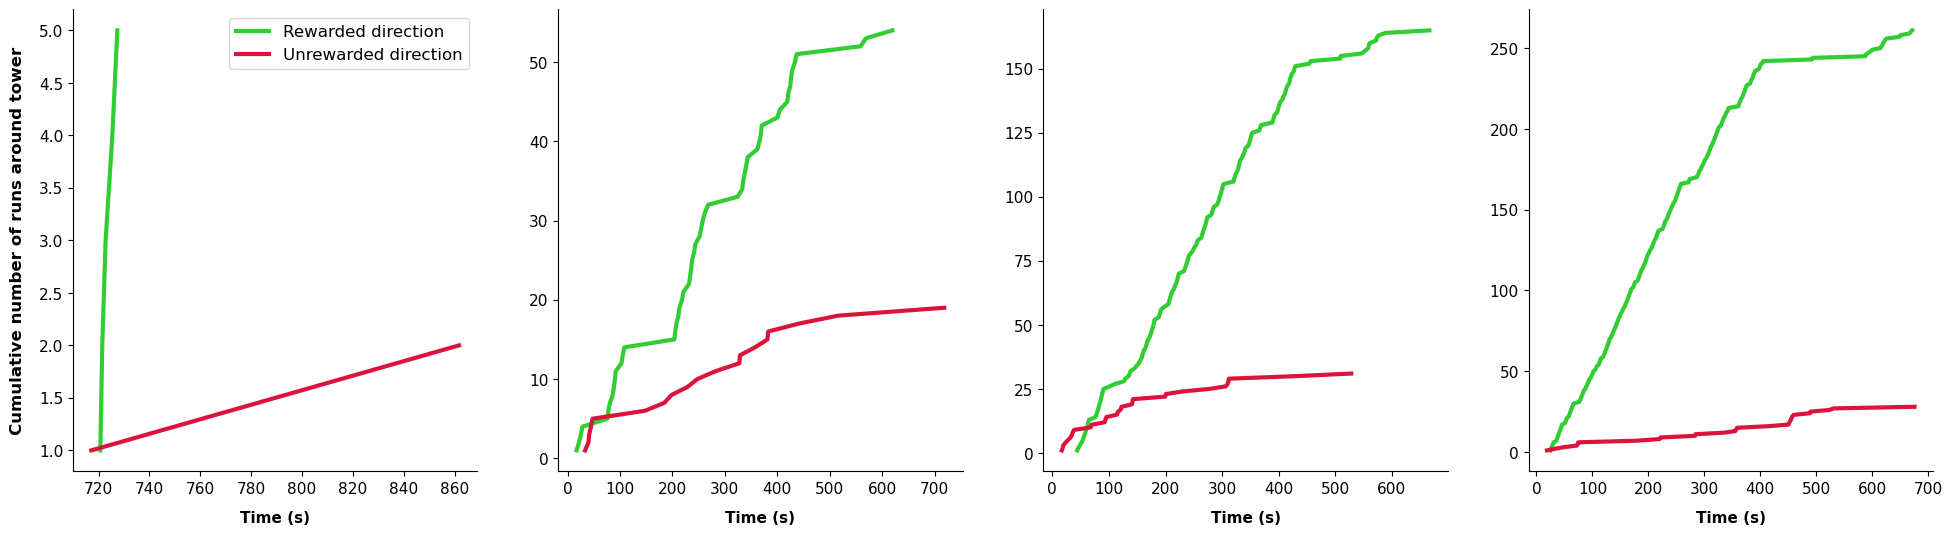

In [31]:
# Plot cumulative number of good and bad turns (for 1 animal)

gc.collect()

def plot_cumulative_rewarded_unrewarded(ax, mouse, session_index, runs_around_tower_dict, direction_dict, set_y_label=True, set_legend=True):

    if mouse not in runs_around_tower_dict:
        print(f"Erreur : la souris '{mouse}' n'existe pas dans le dictionnaire.")
        return

    # Vérification de la présence de la session dans les données de la souris
    if session_index not in runs_around_tower_dict[mouse]:
        print(f"Erreur : la session {session_index} pour la souris '{mouse}' n'existe pas dans le dictionnaire.")
        return

    # Récupération des données
    runs_around_tower = runs_around_tower_dict[mouse][session_index]
    rewarding_direction = direction_dict[mouse][session_index]

    # Create empty lists to store runs
    good_turns = []
    bad_turns = []

    for run in runs_around_tower:
        if run[3]['direction'] == rewarding_direction:
            good_turns.append(run)
        else:
            bad_turns.append(run)

    # Extraire les temps des runs "rewarded" et "unrewarded" dans l'ordre croissant
    good_turns_times_sorted = np.sort(np.array([run[4]['epoch_time'] for run in good_turns]))
    bad_turns_times_sorted = np.sort(np.array([run[4]['epoch_time'] for run in bad_turns]))

    # Calculer les cumulés
    cumulative_good_turns = np.arange(1, len(good_turns) + 1)
    cumulative_bad_turns = np.arange(1, len(bad_turns) + 1)

    # Tracer les courbes cumulatives
    ax.plot(good_turns_times_sorted, cumulative_good_turns, label='Rewarded direction', color='limegreen', lw=3)
    ax.plot(bad_turns_times_sorted, cumulative_bad_turns, label='Unrewarded direction', color='crimson', lw=3)


    # Paramètres du graphique
    ax.set_xlabel('Time (s)', labelpad=10, fontsize=11, fontweight='bold')
    if set_y_label:
        ax.set_ylabel('Cumulative number of runs around tower', labelpad=10, fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=11)
    # ax.set_title('Cumulatif des runs Rewarded et Unrewarded')
    if set_legend:
        ax.legend(fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig, axs = plt.subplots(1,4,figsize=(24,6))
plot_cumulative_rewarded_unrewarded(axs[0], "MOU4562", 0, runs_around_tower_dict, rewarded_direction_per_session)
plot_cumulative_rewarded_unrewarded(axs[1], "MOU4562", 7, runs_around_tower_dict, rewarded_direction_per_session, set_y_label=False, set_legend=False)
plot_cumulative_rewarded_unrewarded(axs[2], "MOU4562", 11, runs_around_tower_dict, rewarded_direction_per_session, set_y_label=False, set_legend=False)
plot_cumulative_rewarded_unrewarded(axs[3], "MOU4562", 17, runs_around_tower_dict, rewarded_direction_per_session, set_y_label=False, set_legend=False)

In [32]:
# Plot individual speed profiles function

gc.collect()

def plot_speed_over_time(ax, mouse, session_index, traject_time_dict, speeds_dict, run_type_dict, xlim=5.1, set_title=False, title_type = 'run not defined', set_y_label=True):
    """
    Trace la vitesse de la souris en fonction du temps pour le type de run spécifié.
    
    Paramètres :
        ax : Axe matplotlib sur lequel dessiner le graphique.
        traject_time (list) : Temps de la trajectoire.
        speeds (list) : Vitesse de la souris.
        runs (list) : Liste des runs pour le type spécifié.
        run_type (str) : Type de run ('between_towers', 'exploratory', 'around_tower').
        color_map (Colormap) : Colormap pour le gradient de couleur.
    """

    if mouse not in run_type_dict:
        print(f"Erreur : la souris '{mouse}' n'existe pas dans le dictionnaire.")
        return

    # Récupération des données
    run_type = run_type_dict[mouse][session_index]
    traject_time = traject_time_dict[mouse][session_index]
    speeds = speeds_dict[mouse][session_index]

    norm = Normalize(vmin=0, vmax=len(run_type))
    color_map = plt.cm.RdPu
    
    for index, run in enumerate(run_type):
        start_index, end_index = run[0][0], run[0][1]
        adjusted_time = [t - traject_time[start_index] for t in traject_time[start_index:end_index + 1]]
        
        # Tracé de la vitesse
        ax.plot(adjusted_time, speeds[start_index:end_index + 1], color=color_map(norm(index)))

    if set_y_label:
        ax.set_ylabel('Speed (cm/s)', labelpad=10, fontsize=11, fontweight='bold')
    ax.set_xlabel('Time (s)', labelpad=10, fontsize = 11, fontweight='bold')
    ax.set_ylim(0, 80)
    ax.set_xlim(0, xlim)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    if set_title:
        ax.set_title(f"Speed profile for {title_type}", pad=10, fontsize=17)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# fig, axs = plt.subplots(1,4,figsize=(24,6))

# plot_speed_over_time(axs[0], "MOU4562", 0, traject_time_dict, speeds_dict, rewarded_QT_dict, xlim=1.7, set_title=False, title_type = 'run not defined', set_y_label=True)
# plot_speed_over_time(axs[1], "MOU4562", 6, traject_time_dict, speeds_dict, runs_around_tower_dict, xlim=1.7, set_title=False, title_type = 'run not defined', set_y_label=False)
# plot_speed_over_time(axs[2], "MOU4562", 12, traject_time_dict, speeds_dict, runs_around_tower_dict, xlim=1.7, set_title=False, title_type = 'run not defined', set_y_label=False)
# plot_speed_over_time(axs[3], "MOU4562", 18, traject_time_dict, speeds_dict, runs_around_tower_dict, xlim=1.7, set_title=False, title_type = 'run not defined', set_y_label=False)


In [33]:
# Plot trajectory type centered

gc.collect()

def plot_trajectory_type_centered(ax, mouse, session_index, X_positions_dict, Y_positions_dict, run_type_dict, 
                                  xlim=30, ylim=30, q=4, line_width=0.5, arrow_width=0.001):
    """
    Trace uniquement la trajectoire, sans cadre ni axes autour de la figure.
    """

    run_type = run_type_dict[mouse][session_index]
    X_positions = X_positions_dict[mouse][session_index]
    Y_positions = Y_positions_dict[mouse][session_index]

    fixed_origin = (0, 0)
    
    for index, run in enumerate(run_type):
        start_index, end_index = run[0][0], run[0][1]
        runtype_epoch_Xpositions = X_positions[start_index:end_index + 1]
        runtype_epoch_Ypositions = Y_positions[start_index:end_index + 1]
        numberofpositions = len(runtype_epoch_Xpositions)
        colorgradientforthisrun = custom_cmap(numberofpositions)
        
        start_x, start_y = runtype_epoch_Xpositions[0], runtype_epoch_Ypositions[0]
        translated_Xpositions = [x - start_x + fixed_origin[0] for x in runtype_epoch_Xpositions]
        translated_Ypositions = [y - start_y + fixed_origin[1] for y in runtype_epoch_Ypositions]
        
        for i in range(numberofpositions - 1):
            ax.plot(translated_Xpositions[i:i+2], translated_Ypositions[i:i+2], 
                    color=colorgradientforthisrun[i], linewidth=line_width)
        
        ax.plot(translated_Xpositions[0], translated_Ypositions[0], 'go', markersize=3)
        
        if len(translated_Xpositions) >= q:
            dx = translated_Xpositions[-1] - translated_Xpositions[-q]
            dy = translated_Ypositions[-1] - translated_Ypositions[-q]
            
            norm_speed = np.hypot(dx, dy)
            if norm_speed != 0:
                dx /= norm_speed
                dy /= norm_speed
            
            ax.arrow(translated_Xpositions[-1], translated_Ypositions[-1], dx, dy,
                     head_width=1, head_length=2, width=arrow_width, fc='red', ec='red')

    # Supprime tous les axes et cadres
    ax.set_xlim(-ylim, ylim)
    ax.set_ylim(-xlim, xlim)
    ax.axis('off')

# fig, axs = plt.subplots(1,4,figsize=(24,6))

# plot_trajectory_type_centered(axs[0], "MOU4562", 0, X_positions_dict, Y_positions_dict, good_turns_dict, xlim=30, ylim=30, q=4, line_width=0.5, arrow_width=0.001)
# plot_trajectory_type_centered(axs[1], "MOU4562", 6, X_positions_dict, Y_positions_dict, good_turns_dict, xlim=30, ylim=30, q=4, line_width=0.5, arrow_width=0.001)
# plot_trajectory_type_centered(axs[2], "MOU4562", 12, X_positions_dict, Y_positions_dict, good_turns_dict, xlim=23, ylim=23, q=4, line_width=3, arrow_width=0.05)
# plot_trajectory_type_centered(axs[3], "MOU4562", 18, X_positions_dict, Y_positions_dict, good_turns_dict, xlim=30, ylim=30, q=4, line_width=0.5, arrow_width=0.001)


In [34]:
# Plot trajectory type

gc.collect()

def plot_run_trajectories(ax, mouse, session_index, trapezes_coordinates_dict, run_type_dict,
                          X_positions_dict, Y_positions_dict, q=4):
    """
    Plots run trajectories around towers, including towers and behavioral data.

    Parameters:
        ax (matplotlib.axes.Axes): Matplotlib Axes on which to plot.
        run_label (str): Label describing the type of runs (e.g., "runs around towers").
        q (int): Minimum number of points to compute and display direction arrows.
        trapezes_coordinates (dict): Coordinates of trapezoidal regions for each tower.
        run_type (list of tuples): List of runs, where each run is represented as [(start, end), ...].
        traject_time (list): Time values corresponding to the trajectory points.
        distances (list): Distance values for each point in the trajectory.
        X_positions_cm (list): X-coordinates of positions in the trajectory.
        Y_positions_cm (list): Y-coordinates of positions  the trajectory.
        speeds (list): Speed values at each point in the trajectory.
        towers_coordinates (dict): Dictionary with tower names as keys and coordinates for each tower as values.
    """

    run_type = run_type_dict[mouse][session_index]
    X_positions = X_positions_dict[mouse][session_index]
    Y_positions = Y_positions_dict[mouse][session_index]
    trapezes_coordinates = trapezes_coordinates_dict[mouse][session_index]

    # Colors for plotting
    fill_colors = ['lightsteelblue'] * 4

    # Remove spines and ticks from the plot
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot each trapezoid region with colors and borders
    for i, (tower, trapezes) in enumerate(trapezes_coordinates.items()):
        for j, (trapeze, coordinates) in enumerate(trapezes.items()):
            coordinates_copy = coordinates + [coordinates[0]]
            x_coords, y_coords = zip(*coordinates_copy)
            ax.fill(x_coords, y_coords, color=fill_colors[j % len(fill_colors)], alpha=0.5)

    # Plot each run trajectory
    for run in run_type:
        start_index, end_index = run[0][0], run[0][1]
        run_X_position = X_positions[start_index:end_index + 1]
        run_Y_position = Y_positions[start_index:end_index + 1]

        # Plot run trajectory with gradient color
        numberofpositions = len(run_X_position)
        colorgradientforthisrun = custom_cmap(numberofpositions)
        for k in range(numberofpositions - 1):
            ax.plot(run_X_position[k:k+2], run_Y_position[k:k+2], linestyle='-', 
                    color=colorgradientforthisrun[k], linewidth=2)

        # Plot start point of the run
        ax.plot(run_X_position[0], run_Y_position[0], 'go', markersize=3)
        ax.set_xlim(10,80)
        ax.set_ylim(10,80)

        # Plot arrow if the trajectory has enough points
        if len(run_X_position) >= q:
            dx = run_X_position[-1] - run_X_position[-q]
            dy = run_Y_position[-1] - run_Y_position[-q]
            norm = np.hypot(dx, dy)
            if norm != 0:
                dx /= norm
                dy /= norm
            ax.arrow(run_X_position[-1], run_Y_position[-1], dx, dy, 
                     head_width=0.8, head_length=1, fc='red', ec='red')
            
# fig, axs = plt.subplots(1,4,figsize=(26,6))

# plot_run_trajectories(axs[0], "MOU4562", 0, trapezes_coordinates_dict, runs_around_tower_dict, X_positions_dict, Y_positions_dict, q=4)
# plot_run_trajectories(axs[1], "MOU4562", 6, trapezes_coordinates_dict, runs_around_tower_dict, X_positions_dict, Y_positions_dict, q=4)
# plot_run_trajectories(axs[2], "MOU4562", 12, trapezes_coordinates_dict, runs_around_tower_dict, X_positions_dict, Y_positions_dict, q=4)
# plot_run_trajectories(axs[3], "MOU4562", 18, trapezes_coordinates_dict, runs_around_tower_dict, X_positions_dict, Y_positions_dict, q=4)


In [35]:
# Figure 1 of learning part

gc.collect()

example_mouse = "MOU4562"
first_session = 0
second_session = 16
third_session = 17
fourth_session = 18
fifth_session = 19

# fig = plt.figure(figsize=(30, 30))

# # Créer une grille personnalisée avec GridSpec
# gs = GridSpec(5, 5, figure=fig)

# # Première ligne : ajouter des sous-graphiques 3D
# axs = {}  # Dictionnaire pour stocker tous les axes
# for i in range(5):
#     axs[(0, i)] = fig.add_subplot(gs[0, i], projection='3d')

# # Lignes restantes : ajouter des sous-graphiques 2D
# for row in range(1, 5):
#     for col in range(5):
#         axs[(row, col)] = fig.add_subplot(gs[row, col])

# # Première ligne : plot trajectory (3D)
# plot_trajectory_3d(axs[(0, 0)], example_mouse, first_session, X_positions_dict, Y_positions_dict, traject_time_dict)
# plot_trajectory_3d(axs[(0, 1)], example_mouse, second_session, X_positions_dict, Y_positions_dict, traject_time_dict, show_axes=False)
# plot_trajectory_3d(axs[(0, 2)], example_mouse, third_session, X_positions_dict, Y_positions_dict, traject_time_dict, show_axes=False)
# plot_trajectory_3d(axs[(0, 3)], example_mouse, fourth_session, X_positions_dict, Y_positions_dict, traject_time_dict, show_axes=False)
# plot_trajectory_3d(axs[(0, 4)], example_mouse, fifth_session, X_positions_dict, Y_positions_dict, traject_time_dict, show_axes=False)

# # Deuxième ligne : plot trajectory (2D)
# plot_run_trajectories(axs[(1, 0)], example_mouse, first_session, trapezes_coordinates_dict, good_turns_dict, X_positions_dict, Y_positions_dict, q=4)
# plot_run_trajectories(axs[(1, 1)], example_mouse, second_session, trapezes_coordinates_dict, good_turns_dict, X_positions_dict, Y_positions_dict, q=4)
# plot_run_trajectories(axs[(1, 2)], example_mouse, third_session, trapezes_coordinates_dict, good_turns_dict, X_positions_dict, Y_positions_dict, q=4)
# plot_run_trajectories(axs[(1, 3)], example_mouse, fourth_session, trapezes_coordinates_dict, good_turns_dict, X_positions_dict, Y_positions_dict, q=4)
# plot_run_trajectories(axs[(1, 4)], example_mouse, fifth_session, trapezes_coordinates_dict, good_turns_dict, X_positions_dict, Y_positions_dict, q=4)

# # Troisième ligne : plot trajectory type centered
# plot_trajectory_type_centered(axs[(2, 0)], example_mouse, first_session, X_positions_dict, Y_positions_dict, good_turns_dict, xlim=25, ylim=25, q=4, line_width=0.5, arrow_width=0.001)
# plot_trajectory_type_centered(axs[(2, 1)], example_mouse, second_session, X_positions_dict, Y_positions_dict, good_turns_dict, xlim=25, ylim=25, q=4, line_width=0.5, arrow_width=0.001)
# plot_trajectory_type_centered(axs[(2, 2)], example_mouse, third_session, X_positions_dict, Y_positions_dict, good_turns_dict, xlim=25, ylim=25, q=4, line_width=0.5, arrow_width=0.001)
# plot_trajectory_type_centered(axs[(2, 3)], example_mouse, fourth_session, X_positions_dict, Y_positions_dict, good_turns_dict, xlim=25, ylim=25, q=4, line_width=0.5, arrow_width=0.001)
# plot_trajectory_type_centered(axs[(2, 4)], example_mouse, fifth_session, X_positions_dict, Y_positions_dict, good_turns_dict, xlim=25, ylim=25, q=4, line_width=0.5, arrow_width=0.001)

# # Quatrième ligne : plot cumulative rewarded/unrewarded
# plot_cumulative_rewarded_unrewarded(axs[(3, 0)], example_mouse, first_session, runs_around_tower_dict, rewarded_direction_per_session)
# plot_cumulative_rewarded_unrewarded(axs[(3, 1)], example_mouse, second_session, runs_around_tower_dict, rewarded_direction_per_session, set_y_label=False, set_legend=False)
# plot_cumulative_rewarded_unrewarded(axs[(3, 2)], example_mouse, third_session, runs_around_tower_dict, rewarded_direction_per_session, set_y_label=False, set_legend=False)
# plot_cumulative_rewarded_unrewarded(axs[(3, 3)], example_mouse, fourth_session, runs_around_tower_dict, rewarded_direction_per_session, set_y_label=False, set_legend=False)
# plot_cumulative_rewarded_unrewarded(axs[(3, 4)], example_mouse, fifth_session, runs_around_tower_dict, rewarded_direction_per_session, set_y_label=False, set_legend=False)

# # Cinquième ligne : plot speed profiles
# plot_speed_over_time(axs[(4, 0)], example_mouse, first_session, traject_time_dict, speeds_dict, good_turns_dict, xlim=1.7, set_title=False, title_type='run not defined', set_y_label=True)
# plot_speed_over_time(axs[(4, 1)], example_mouse, second_session, traject_time_dict, speeds_dict, good_turns_dict, xlim=1.7, set_title=False, title_type='run not defined', set_y_label=False)
# plot_speed_over_time(axs[(4, 2)], example_mouse, third_session, traject_time_dict, speeds_dict, good_turns_dict, xlim=1.7, set_title=False, title_type='run not defined', set_y_label=False)
# plot_speed_over_time(axs[(4, 3)], example_mouse, fourth_session, traject_time_dict, speeds_dict, good_turns_dict, xlim=1.7, set_title=False, title_type='run not defined', set_y_label=False)
# plot_speed_over_time(axs[(4, 4)], example_mouse, fifth_session, traject_time_dict, speeds_dict, good_turns_dict, xlim=1.7, set_title=False, title_type='run not defined', set_y_label=False)


# plt.show()
# gc.collect()

### Figure 2 : Plot learning curves

In [36]:
# Plot flexibility ratio for example mouse 

# def plot_flexibility_ratio(ax, mouse, ratio_dict, show_legend=True):
#     """
#     Plot the evolution of the CW/CCW flexibility ratio for a given mouse.

#     Parameters:
#         mouse (str): Mouse identifier.
#         ratio_dict (dict): Dictionary containing the CW/CCW ratio for each mouse and session index.
#         title (str): Title of the plot.
#     """
#     # Extraire les sessions et les ratios pour la souris donnée
#     sessions = list(ratio_dict[mouse].keys())
#     ratios = [ratio_dict[mouse][session] for session in sessions]
    
#     # Ajouter les bandes grises pour les sessions à index impair
#     for session_index in sessions:
#         if session_index % 2 != 0:  # Impair
#             ax.axvspan(session_index - 0.5, session_index + 0.5, color="#b7b7b7",
#                        alpha=0.5, zorder=0, label="PM sessions")
        
#         direction = rewarded_direction_per_session[mouse][session_index]

#         if direction == "both":
#             color = "#a875bc"
#         elif direction == "CW":
#             color = "#89b1f4"
#         elif direction == "CCW":
#             color = "#db6c9a"
#         else:
#             continue  # Ignorer si aucune direction spécifiée
#         # Tracer la bande fine
#         ax.axvspan(session_index - 0.49, session_index + 0.49, ymin=0.979, ymax=0.998,
#                    color=color, zorder=3, clip_on=False)
    
#     ax.plot(sessions, ratios, color="black", lw=1, zorder=1)

#     # Tracer la courbe
#     # for session, ratio in zip(sessions, ratios):
#     #     if session <= 3 or session >= 34:  # À partir de l'index 34
#     #         color = "#a875bc"
#     #     else:
#     #         color = "#89b1f4" if ratio > 0 else "#db6c9a"
#     #     ax.plot(session, ratio, marker="o", color=color, lw=1, zorder=2)
    
#     # Personnaliser les axes
#     ax.axhline(y=0, color="black", linestyle="--", linewidth=0.8, zorder=1)
#     ax.set_xticks(sessions)
#     ax.set_xticklabels([str(session + 1) for session in sessions], fontsize=9)
#     ax.set_xlabel("Sessions")
#     ax.set_ylabel("Flexibility ratio", labelpad=30)
    
#     # Ajuster les limites des axes
#     ax.set_xlim(sessions[0] - 0.5, sessions[-1] + 0.5)
#     ax.set_ylim(-1, 1)

#     # Afficher la légende
#     if show_legend:
#         ax.legend(loc="upper left")

# # Création du plot
# fig, ax = plt.subplots(figsize=(16, 4))
# plot_flexibility_ratio(ax, mouse, ratio_CW_CCW_dict, show_legend=False)
# plt.show()

In [37]:
def plot_flexibility_ratios(ax, ratio_dict, groups, group_type="All", show_legend=False):
    """
    Plot the evolution of the CW/CCW flexibility ratio for all mice in a specified group,
    with a median curve highlighted in black.

    Parameters:
        ax (matplotlib.axes.Axes): The axes to plot on.
        ratio_dict (dict): Dictionary containing the CW/CCW ratio for each mouse and session index.
        groups (dict): Dictionary of groups and their associated mice.
        group_type (str): The group type (e.g., "D1 DLS"). Default is "All".
        show_legend (bool): Whether to show the legend.
    """
    # Get the mice list for the specified group type
    if group_type not in groups:
        raise ValueError(f"Group type '{group_type}' not found in groups.")
    mice_list = groups[group_type]

    # Get the colormap for the group type
    if group_type not in colormaps:
        raise ValueError(f"Colormap not defined for group type '{group_type}'")
    cmap = cm.get_cmap(colormaps[group_type], len(mice_list))
    
    # Generate colors for each mouse
    colors = [cmap(i / (len(mice_list) - 1)) for i in range(len(mice_list))]

    # Collect all session indices and ratios for median calculation
    all_sessions = sorted({session for mouse in mice_list for session in ratio_dict[mouse].keys()})
    all_ratios = {session: [] for session in all_sessions}

    for idx, (mouse, color) in enumerate(zip(mice_list, colors)):
        # Extract sessions and ratios for the given mouse
        sessions = list(ratio_dict[mouse].keys())
        ratios = [ratio_dict[mouse][session] for session in sessions]

        # Add to all_ratios for median calculation
        for session, ratio in zip(sessions, ratios):
            all_ratios[session].append(ratio)

        # Add gray bands for PM sessions (odd sessions)
        for session_index in sessions:
            if session_index % 2 != 0:  # Odd
                ax.axvspan(session_index - 0.5, session_index + 0.5, color="#efefef",
                           alpha=0.5, zorder=0, label="PM sessions" if idx == 0 else None)
            
            # Highlight rewarded directions
            direction = rewarded_direction_per_session[mouse][session_index]
            if direction == "both":
                band_color = "#a875bc"
            elif direction == "CW":
                band_color = "#89b1f4"
            elif direction == "CCW":
                band_color = "#db6c9a"
            else:
                continue  # Skip if no direction specified

            ax.axvspan(session_index - 0.49, session_index + 0.49, ymin=0.979, ymax=0.998,
                       color=band_color, zorder=3, clip_on=False)

        # Plot the flexibility ratio for the mouse
        ax.plot(sessions, ratios, label=mouse, color=color, lw=1.5, zorder=2, alpha=0.3)

    # Calculate and plot the median
    median_ratios = [np.median(all_ratios[session]) for session in all_sessions]
    ax.plot(all_sessions, median_ratios, color="black", lw=3, zorder=4, label="Median")

    # Customize the plot
    ax.axhline(y=0, color="black", linestyle="--", linewidth=0.8, zorder=1)
    ax.set_xticks(all_sessions)
    ax.set_xticklabels([str(session + 1) for session in all_sessions], fontsize=9)
    ax.set_xlabel("Sessions", fontsize=12, fontweight='bold')
    ax.set_ylabel("Flexibility ratio", labelpad=40, fontsize=12, fontweight='bold')
    ax.set_xlim(all_sessions[0] - 0.5, all_sessions[-1] + 0.5)
    ax.set_ylim(-1, 1)

    # Show legend
    if show_legend:
        ax.legend(title=f"{group_type} mice", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)

# Example of usage
# fig, ax = plt.subplots(figsize=(16, 6))
# plot_flexibility_ratios(ax, ratio_CW_CCW_dict, groups_D1_D2, group_type="D1", show_legend=False)
# plt.tight_layout()
# plt.show()


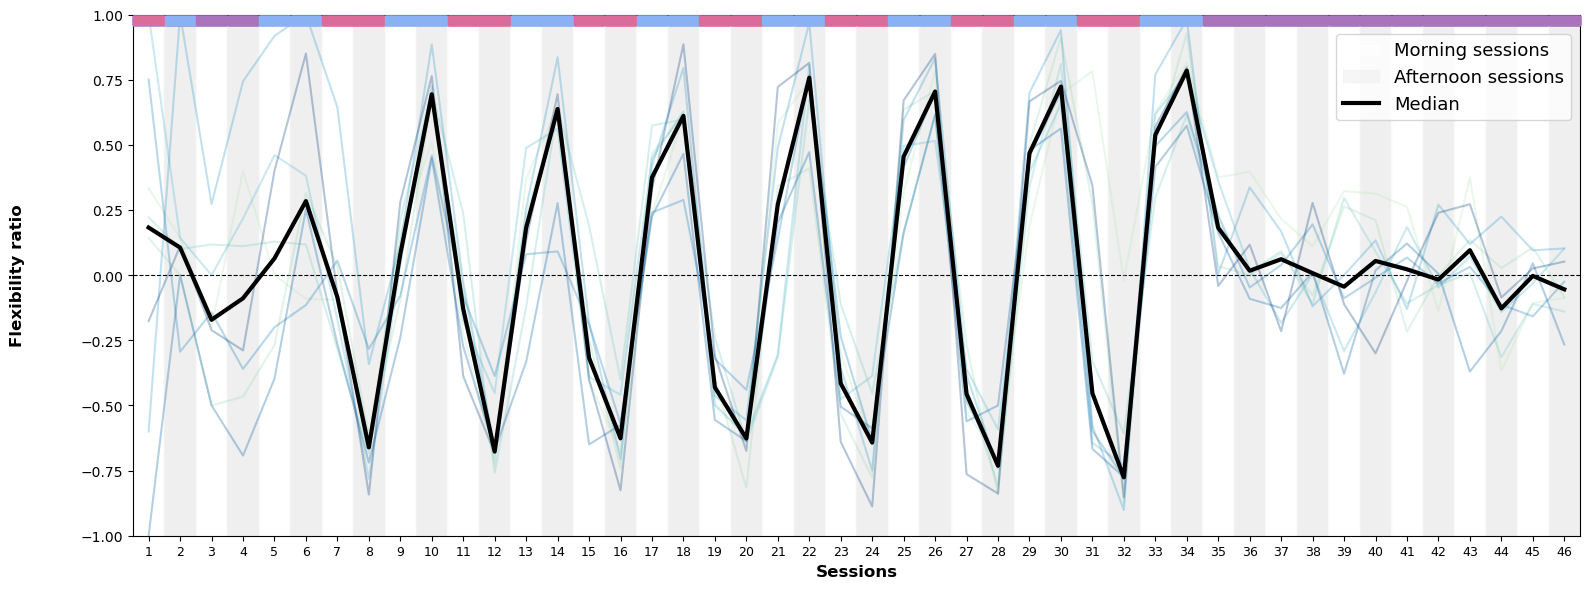

In [38]:
def plot_flexibility_ratios(ax, ratio_dict, groups, group_type="All", show_legend=False):
    """
    Plot the evolution of the CW/CCW flexibility ratio for all mice in a specified group,
    with a median curve highlighted in black.

    Parameters:
        ax (matplotlib.axes.Axes): The axes to plot on.
        ratio_dict (dict): Dictionary containing the CW/CCW ratio for each mouse and session index.
        groups (dict): Dictionary of groups and their associated mice.
        group_type (str): The group type (e.g., "D1 DLS"). Default is "All".
        show_legend (bool): Whether to show the legend.
    """
    # Get the mice list for the specified group type
    if group_type not in groups:
        raise ValueError(f"Group type '{group_type}' not found in groups.")
    mice_list = groups[group_type]

    # Get the colormap for the group type
    if group_type not in colormaps:
        raise ValueError(f"Colormap not defined for group type '{group_type}'")
    cmap = cm.get_cmap(colormaps[group_type], len(mice_list))
    
    # Generate colors for each mouse
    colors = [cmap(i / (len(mice_list) - 1)) for i in range(len(mice_list))]

    # Collect all session indices and ratios for median calculation
    all_sessions = sorted({session for mouse in mice_list for session in ratio_dict[mouse].keys()})
    all_ratios = {session: [] for session in all_sessions}

    # Handles for legend
    morning_handle = None
    afternoon_handle = None
    median_handle = None

    for idx, (mouse, color) in enumerate(zip(mice_list, colors)):
        # Extract sessions and ratios for the given mouse
        sessions = list(ratio_dict[mouse].keys())
        ratios = [ratio_dict[mouse][session] for session in sessions]

        # Add to all_ratios for median calculation
        for session, ratio in zip(sessions, ratios):
            all_ratios[session].append(ratio)

        # Add gray bands for PM sessions (odd sessions)
        for session_index in sessions:
            if session_index % 2 != 0:  # Odd (PM sessions)
                if afternoon_handle is None:
                    afternoon_handle = ax.axvspan(
                        session_index - 0.5, session_index + 0.5,
                        color="#efefef", alpha=0.5, zorder=0, label="Afternoon sessions"
                    )
                else:
                    ax.axvspan(
                        session_index - 0.5, session_index + 0.5,
                        color="#efefef", alpha=0.5, zorder=0
                    )
            else:  # Even (AM sessions)
                if morning_handle is None:
                    morning_handle = ax.axvspan(
                        session_index - 0.5, session_index + 0.5,
                        color="white", alpha=0.5, zorder=0, label="Morning sessions"
                    )
                else:
                    ax.axvspan(
                        session_index - 0.5, session_index + 0.5,
                        color="white", alpha=0.5, zorder=0
                    )
            
            # Highlight rewarded directions
            direction = rewarded_direction_per_session[mouse][session_index]
            if direction == "both":
                band_color = "#a875bc"
            elif direction == "CW":
                band_color = "#89b1f4"
            elif direction == "CCW":
                band_color = "#db6c9a"
            else:
                continue  # Skip if no direction specified

            ax.axvspan(session_index - 0.49, session_index + 0.49, ymin=0.979, ymax=0.998,
                       color=band_color, zorder=3, clip_on=False)

        # Plot the flexibility ratio for the mouse
        ax.plot(sessions, ratios, label=mouse, color=color, lw=1.5, zorder=2, alpha=0.3)

    # Calculate and plot the median
    median_ratios = [np.median(all_ratios[session]) for session in all_sessions]
    median_handle, = ax.plot(all_sessions, median_ratios, color="black", lw=3, zorder=4, label="Median")

    # Customize the plot
    ax.axhline(y=0, color="black", linestyle="--", linewidth=0.8, zorder=1)
    ax.set_xticks(all_sessions)
    ax.set_xticklabels([str(session + 1) for session in all_sessions], fontsize=9)
    ax.set_xlabel("Sessions", fontsize=12, fontweight='bold')
    ax.set_ylabel("Flexibility ratio", labelpad=40, fontsize=12, fontweight='bold')
    ax.set_xlim(all_sessions[0] - 0.5, all_sessions[-1] + 0.5)
    ax.set_ylim(-1, 1)

    # Show legend
    if show_legend:
        # Add custom handles
        custom_handles = [morning_handle, afternoon_handle, median_handle]
        custom_labels = ["Morning sessions", "Afternoon sessions", "Median"]
        ax.legend(handles=custom_handles, labels=custom_labels, loc="upper right", bbox_to_anchor=(1, 0.98), fontsize=13)


# Example of usage
fig, ax = plt.subplots(figsize=(16, 6))
plot_flexibility_ratios(ax, ratio_CW_CCW_dict, groups_D1_D2, group_type="D1", show_legend=True)
plt.tight_layout()
plt.show()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

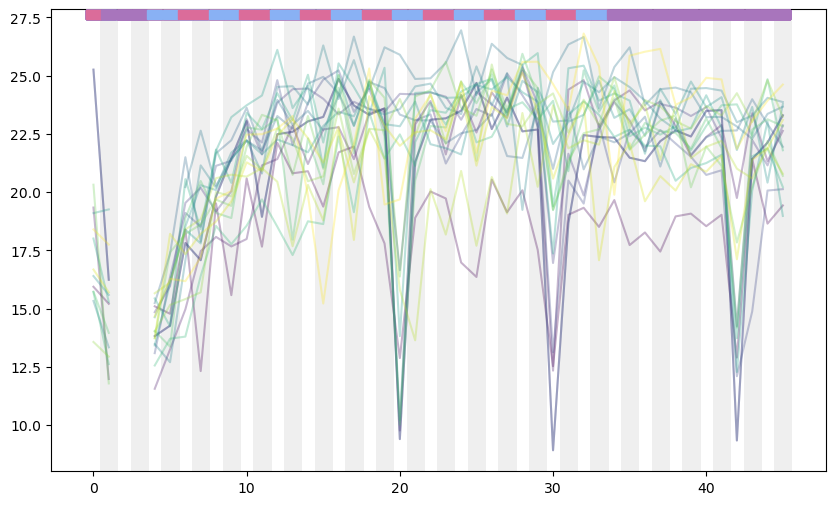

In [42]:
def plot_rewarded_mean_speeds(ax, speed_dict, groups, group_type="All", show_legend=False):
    """
    Plot the evolution of the mean speeds for rewarded trials for all mice in a specified group,
    with a median curve highlighted in black.

    Parameters:
        ax (matplotlib.axes.Axes): The axes to plot on.
        speed_dict (dict): Dictionary containing the mean speed for each mouse and session index.
        groups (dict): Dictionary of groups and their associated mice.
        group_type (str): The group type (e.g., "D1 DLS"). Default is "All".
        show_legend (bool): Whether to show the legend.
    """
    # Get the mice list for the specified group type
    if group_type not in groups:
        raise ValueError(f"Group type '{group_type}' not found in groups.")
    mice_list = groups[group_type]

    # Get the colormap for the group type
    if group_type not in colormaps:
        raise ValueError(f"Colormap not defined for group type '{group_type}'")
    cmap = cm.get_cmap(colormaps[group_type], len(mice_list))
    
    # Generate colors for each mouse
    colors = [cmap(i / (len(mice_list) - 1)) for i in range(len(mice_list))]

    # Collect all session indices and speeds for median calculation
    all_sessions = sorted({session for mouse in mice_list for session in speed_dict[mouse].keys()})
    all_speeds = {session: [] for session in all_sessions}

    for idx, (mouse, color) in enumerate(zip(mice_list, colors)):
        # Extract sessions and mean speeds for the given mouse
        sessions = list(speed_dict[mouse].keys())
        speeds = [speed_dict[mouse][session] for session in sessions]

        # Add to all_speeds for median calculation
        for session, speed in zip(sessions, speeds):
            all_speeds[session].append(speed)

        # Add gray bands for PM sessions (odd sessions)
        for session_index in sessions:
            if session_index % 2 != 0:  # Odd sessions
                ax.axvspan(session_index - 0.5, session_index + 0.5, color="#efefef",
                           alpha=0.5, zorder=0, label="PM sessions" if idx == 0 else None)
            
            # Highlight rewarded directions
            direction = rewarded_direction_per_session[mouse][session_index]
            if direction == "both":
                band_color = "#a875bc"
            elif direction == "CW":
                band_color = "#89b1f4"
            elif direction == "CCW":
                band_color = "#db6c9a"
            else:
                continue  # Skip if no direction specified

            ax.axvspan(session_index - 0.49, session_index + 0.49, ymin=0.979, ymax=0.998,
                       color=band_color, zorder=3, clip_on=False)

        # Plot the mean speed for the mouse
        ax.plot(sessions, speeds, label=mouse, color=color, lw=1.5, zorder=2, alpha=0.3)

    # Calculate and plot the median speed
    median_speeds = [np.nanmedian(all_speeds[session]) for session in all_sessions]
    ax.plot(all_sessions, median_speeds, color="black", lw=3, zorder=4, label="Median")

    # Customize the plot
    ax.axhline(y=0, color="black", linestyle="--", linewidth=0.8, zorder=1)
    ax.set_xticks(all_sessions)
    ax.set_xticklabels([str(session + 1) for session in all_sessions], fontsize=9)
    ax.set_xlabel("Sessions", fontsize=12, fontweight='bold')
    ax.set_ylabel("Median of rewarded QT mean speed", labelpad=40, fontsize=12, fontweight='bold')
    ax.set_xlim(all_sessions[0] - 0.5, all_sessions[-1] + 0.5)
    ax.set_ylim(5, np.nanmax(median_speeds) + 5)  # Add a small margin above the max speed
    # ax.set_ylim(0,550)

    highlight_sessions = {17: "blue", 19: "green", 20: "red", 22: "green", 23:"yellow", 25:"yellow"}
    for session_idx, color in highlight_sessions.items():
        ax.axvspan(session_idx - 0.5, session_idx + 0.5, color=color, alpha=0.2, zorder=0)

    # Show legend
    if show_legend:
        ax.legend(title=f"{group_type} mice", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)

# Example of usage
fig, ax = plt.subplots(figsize=(10, 6))
plot_rewarded_mean_speeds(ax, med_unrew_meanspeeds, groups, group_type="All", show_legend=False)
plt.tight_layout()
plt.show()

#med_rew_meanspeeds #total_QT_rewarded_dict #total_QT_dict # med_unrew_meanspeeds

In [43]:
# Functions for plotting metrics over sessions

# def plot_metric_over_sessions(ax, example_mouse, metric_dict, group_dict, colormaps, title="Metric Over Sessions", ylabel="Metric"):
#     """
#     Plots a given metric over sessions with individual data in transparency and the group median in black.
    
#     Parameters:
#         ax (matplotlib.axes.Axes): Axes object on which to plot.
#         metric_dict (dict): Dictionary of metrics with mouse IDs as keys and session indices as nested keys.
#         group_dict (dict): Dictionary mapping mouse IDs to their group (e.g., "D1 DLS").
#         colormaps (dict): Dictionary mapping groups to colormap names (e.g., {"D1 DLS": "Greens"}).
#         title (str): Title of the plot.
#         ylabel (str): Label for the y-axis.
#     """
#     all_sessions_data = {}  # Collect session-wise data for median computation

#     for group, animals in group_dict.items():
#         # Récupérer la colormap pour chaque groupe
#         cmap = cm.get_cmap(colormaps.get(group, "gray"))
        
#         # Pour chaque souris dans ce groupe, on trace sa courbe avec une couleur spécifique
#         for idx, mouse in enumerate(animals):
#             session_data = metric_dict.get(mouse, {})
            
#             # Calculer la couleur à appliquer (plus clair pour les premières souris et plus foncé pour les dernières)
#             color = cmap((idx + 1) / len(animals))  # Échelle de couleur entre 0 et 1
            
#             # Extraire les valeurs x et y pour chaque souris
#             x_values = sorted(session_data.keys())
#             y_values = [session_data[session_idx] for session_idx in x_values]

#             # Mettre à jour les données pour le calcul de la médiane
#             for session_idx, value in session_data.items():
#                 if session_idx not in all_sessions_data:
#                     all_sessions_data[session_idx] = []
#                 all_sessions_data[session_idx].append(value)

#             # Tracer les données individuelles avec la couleur spécifiée
#             if mouse == example_mouse:
#                 ax.plot([x for x in x_values], y_values, color="#e06666", lw=2, alpha=1, zorder=2)
#             else:
#                 ax.plot([x for x in x_values], y_values, color=color, alpha=0.3, zorder=1)

#     # Calculer et tracer la médiane pour toutes les souris par session
#     median_x = sorted(all_sessions_data.keys())
#     median_y = [np.median(all_sessions_data[idx]) for idx in median_x]
#     ax.plot([x for x in median_x], median_y, color="black", lw=2, zorder=3)

#     # Définir les positions des ticks en X
#     tick_positions = [0, 9, 19, 29, 39]  # Positions des ticks pour les numéros de session
#     ax.set_xticks(tick_positions)
#     ax.set_xticklabels([str(tick + 1) for tick in tick_positions])  # Correspondance session_index + 1

#     # Personnaliser le graphique
#     ax.set_title(title)
#     ax.set_xlabel("Session number", fontsize=11, fontweight='bold')
#     ax.set_ylabel(ylabel, fontsize=11, fontweight='bold')
#     # ax.legend(loc="upper right", fontsize="small", frameon=False)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

# # Exemple d'utilisation avec des données fictives
# fig, ax = plt.subplots(figsize=(6,6))
# plot_metric_over_sessions(ax, example_mouse, meanspeed_QT_dict, groups, colormaps, title=None, ylabel="Mean speed of turns in rewarded direction")
# plt.show()

In [44]:
def plot_metric_over_sessions_split(ax, example_mouse, metric_dict, group_dict, colormaps, 
                                    title="Metric Over Sessions", ylabel="Metric", show_legend=False):
    """
    Plots a given metric over two separate session ranges as two independent plots within the same axes.
    Adds a visible blank space between the two ranges, and there is no visual connection between them.
    
    Parameters:
        ax (matplotlib.axes.Axes): Axes object on which to plot.
        example_mouse (str): Mouse ID to highlight with a specific color.
        metric_dict (dict): Dictionary of metrics with mouse IDs as keys and session indices as nested keys.
        group_dict (dict): Dictionary mapping mouse IDs to their group (e.g., "D1 DLS").
        colormaps (dict): Dictionary mapping groups to colormap names (e.g., {"D1 DLS": "Greens"}).
        title (str): Title of the plot.
        ylabel (str): Label for the y-axis.
    """
    # Define the two ranges
    ranges = [(0, 19), (33, 41)]
    all_sessions_data = {idx: [] for r in ranges for idx in range(r[0], r[1] + 1)}  # Collect session-wise data
    
    # Remap the x-axis indices to remove gaps and add a blank space
    remapped_x = {}
    current_x = 0
    gap_size = 5  # Define the blank space size between ranges

    for start, end in ranges:
        for session in range(start, end + 1):
            remapped_x[session] = current_x
            current_x += 1
        current_x += gap_size  # Add blank space after each range

    median_plotted = False  # Flag for median label
    example_mouse_plotted = False  # Flag for example mouse label

    # Plot data for each group
    for group, animals in group_dict.items():
        cmap = cm.get_cmap(colormaps.get(group, "gray"))
        for idx, mouse in enumerate(animals):
            session_data = metric_dict.get(mouse, {})
            color = cmap((idx + 1) / len(animals))

            # Plot each range independently
            for start, end in ranges:
                x_values = [remapped_x[s] for s in session_data.keys() if start <= s <= end]
                y_values = [session_data[s] for s in session_data.keys() if start <= s <= end]

                # Update all_sessions_data for median calculation
                for session_idx, value in session_data.items():
                    if start <= session_idx <= end:
                        all_sessions_data[session_idx].append(value)

                # Plot individual data
                if mouse == example_mouse:
                    if not example_mouse_plotted:
                        ax.plot(x_values, y_values, color="#e06666", lw=2, alpha=1, zorder=2, label='Example mouse')
                        example_mouse_plotted = True
                    else: 
                        ax.plot(x_values, y_values, color="#e06666", lw=2, alpha=1, zorder=2)
                else:
                    ax.plot(x_values, y_values, color=color, alpha=0.2, zorder=1)

    # Plot median data
    for start, end in ranges:
        median_x = [remapped_x[s] for s in range(start, end + 1)]
        median_y = [np.median(all_sessions_data[s]) for s in range(start, end + 1)]
        if not median_plotted:
            ax.plot(median_x, median_y, color="black", lw=3, zorder=3, label = 'Median')
            median_plotted = True
        else:
            ax.plot(median_x, median_y, color="black", lw=3, zorder=3)

    # Customize x-axis ticks and labels
    ticks = [remapped_x[s] for s in remapped_x]
    labels = [str(s + 1) for s in remapped_x]
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, fontsize=8)

    # Customize plot
    ax.set_title(title)
    ax.set_xlabel("Session number", fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold', labelpad=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if show_legend:
        ax.legend(loc="upper left")

# fig, ax = plt.subplots(figsize=(10,6))
# plot_metric_over_sessions_split(ax, example_mouse, total_QT_rewarded_dict, groups, colormaps, title=None, ylabel="Total nb of rewarded turns", show_legend=True)
# plt.show()


In [45]:
# Function to plot metric over first and last 3 sessions (paired comparison)

# def plot_first_vs_last3(ax, example_mouse, metric_dict, group_dict, colormaps, title="First vs Last 3 Sessions", ylabel="Metric", show_legend = True):
#     """
#     Plots a comparison of a metric between the first session and the last 3 sessions (up to session 19).
    
#     Parameters:
#         ax (matplotlib.axes.Axes): Axes object on which to plot.
#         metric_dict (dict): Dictionary of metrics with mouse IDs as keys and session indices as nested keys.
#         group_dict (dict): Dictionary mapping mouse IDs to their group (e.g., "D1 DLS").
#         colormaps (dict): Dictionary mapping groups to colormap names (e.g., {"D1 DLS": "Greens"}).
#         title (str): Title of the plot.
#         ylabel (str): Label for the y-axis.
#     """
#     first_sessions = []
#     last_sessions = []
    
#     for group, animals in group_dict.items():
#         # Récupérer la colormap pour chaque groupe
#         cmap = cm.get_cmap(colormaps.get(group, "gray"))
        
#         # Pour chaque souris dans ce groupe, on trace sa courbe avec une couleur spécifique
#         for idx, mouse in enumerate(animals):
#             session_data = metric_dict.get(mouse, {})
            
#             # Calculer la couleur à appliquer (plus clair pour les premières souris et plus foncé pour les dernières)
#             color = cmap((idx + 1) / len(animals))  # Échelle de couleur entre 0 et 1

#             # Limiter aux sessions jusqu'à l'index 19 (si l'animal a plus de sessions)
#             session_data = {k: v for k, v in session_data.items() if k <= 19}
            
#             if len(session_data) > 0:
#                 # Récupérer la première session (session 0)
#                 first_session = session_data.get(0, np.nan)
                
#                 # Récupérer les 3 dernières sessions (en prenant la plage de sessions de l'animal)
#                 session_indices = sorted(session_data.keys())[-3:]  # Les 3 derniers indices disponibles
#                 last_3_sessions = [session_data.get(i, np.nan) for i in session_indices]
                
#                 # Calculer la médiane des 3 dernières sessions
#                 last_3_session_median = np.median(last_3_sessions) if len(last_3_sessions) >= 3 else np.nan
#                 first_sessions.append(first_session)
#                 last_sessions.append(last_3_session_median)

#                 # Tracer les données individuelles (comparaison de la première et des 3 dernières sessions)
#                 if mouse == example_mouse:
#                     ax.plot(
#                         ["First session", "Last 3 sessions"], 
#                         [first_session, last_3_session_median], 
#                         color="#e06666", alpha=1, lw=3, label="Example mouse", zorder=2)
#                     ax.scatter("First session", first_session, color="#e06666", alpha=1, zorder=2, s=100)
#                     ax.scatter("Last 3 sessions", last_3_session_median, color="#e06666", alpha=1, zorder=2, s=100)

#                 else:
#                     ax.plot(["First session", "Last 3 sessions"], [first_session, last_3_session_median], 
#                             color=color, alpha=0.4, zorder=1)
#                     ax.scatter("First session", first_session, color=color, alpha=0.4, zorder=3, s=50)
#                     ax.scatter("Last 3 sessions", last_3_session_median, color=color, alpha=0.4, zorder=3)


#     # Calculer la médiane pour la "First session" et les "Last 3 sessions"
#     first_median = np.nanmedian(first_sessions)
#     last_median = np.nanmedian(last_sessions)

#     # Tracer les médianes
#     ax.plot(["First session", "Last 3 sessions"], [first_median, last_median], color="black", lw=3, label="Median", zorder=3)
#     ax.scatter(["First session", "Last 3 sessions"], [first_median, last_median], color="black", zorder=3, s=50)

#     # Test statistique de Wilcoxon (exclure les valeurs NaN)
#     valid_pairs = [(f, l) for f, l in zip(first_sessions, last_sessions) if not (np.isnan(f) or np.isnan(l))]
#     if len(valid_pairs) > 0:
#         first_vals, last_vals = zip(*valid_pairs)
#         try:
#             stat, p_value = wilcoxon(first_vals, last_vals)
#         except ValueError:  # Si le test échoue (par exemple, si toutes les valeurs sont identiques)
#             p_value = np.nan
#     else:
#         p_value = np.nan

#     # Ajouter la p-value sur le graphique si significative
#     if not np.isnan(p_value):
#         ax.text(0.5, 0.95, f"p = {p_value:.5f}", transform=ax.transAxes, 
#                 ha="center", va="top", fontsize=12)

#     # Personnaliser le graphique
#     if title is not None:
#         ax.set_title(title, fontweight='bold', fontsize=14)
#     ax.set_ylabel(ylabel, fontweight='bold', fontsize=12)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     if show_legend:
#         ax.legend(loc="upper left", bbox_to_anchor=(0, 0.9))

# Exemple d'utilisation avec des données fictives
# fig, ax = plt.subplots(figsize=(4,6))
# plot_first_vs_last3(ax, example_mouse, time_trapeze_minus_border, groups, colormaps, title="First vs Last 3 Sessions", ylabel="Difference in time (trapeze-border)")
# plt.show()

In [46]:
# Créer une figure avec 5 lignes et 1 colonne
# fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 30), 
#                         gridspec_kw={'height_ratios': [1, 1, 1, 1, 1]})  # Ajuste les height ratios ici

# # Trace chaque graphique sur une ligne différente
# plot_flexibility_ratios(axs[0], ratio_CW_CCW_dict, groups_D1_D2, group_type="D1", show_legend=False)
# plot_flexibility_ratios(axs[1], ratio_CW_CCW_dict, groups_D1_D2, group_type="D2", show_legend=False)
# plot_metric_over_sessions_split(axs[2], example_mouse, total_QT_rewarded_dict, groups, colormaps, title=None, ylabel="Total nb of rewarded turns")
# plot_metric_over_sessions_split(axs[3], example_mouse, meanspeed_QT_dict, groups, colormaps, title=None, ylabel="Mean speed of turns in rewarded direction")
# plot_metric_over_sessions_split(axs[4], example_mouse, total_QT_unrewarded_dict, groups, colormaps, title=None, ylabel="Total nb of unrewarded turns")

# # Ajuste la mise en page pour éviter les chevauchements
# plt.tight_layout()  # Le padding vertical entre les graphiques peut être ajusté ici

# # Afficher la figure
# plt.show()


KeyboardInterrupt: 

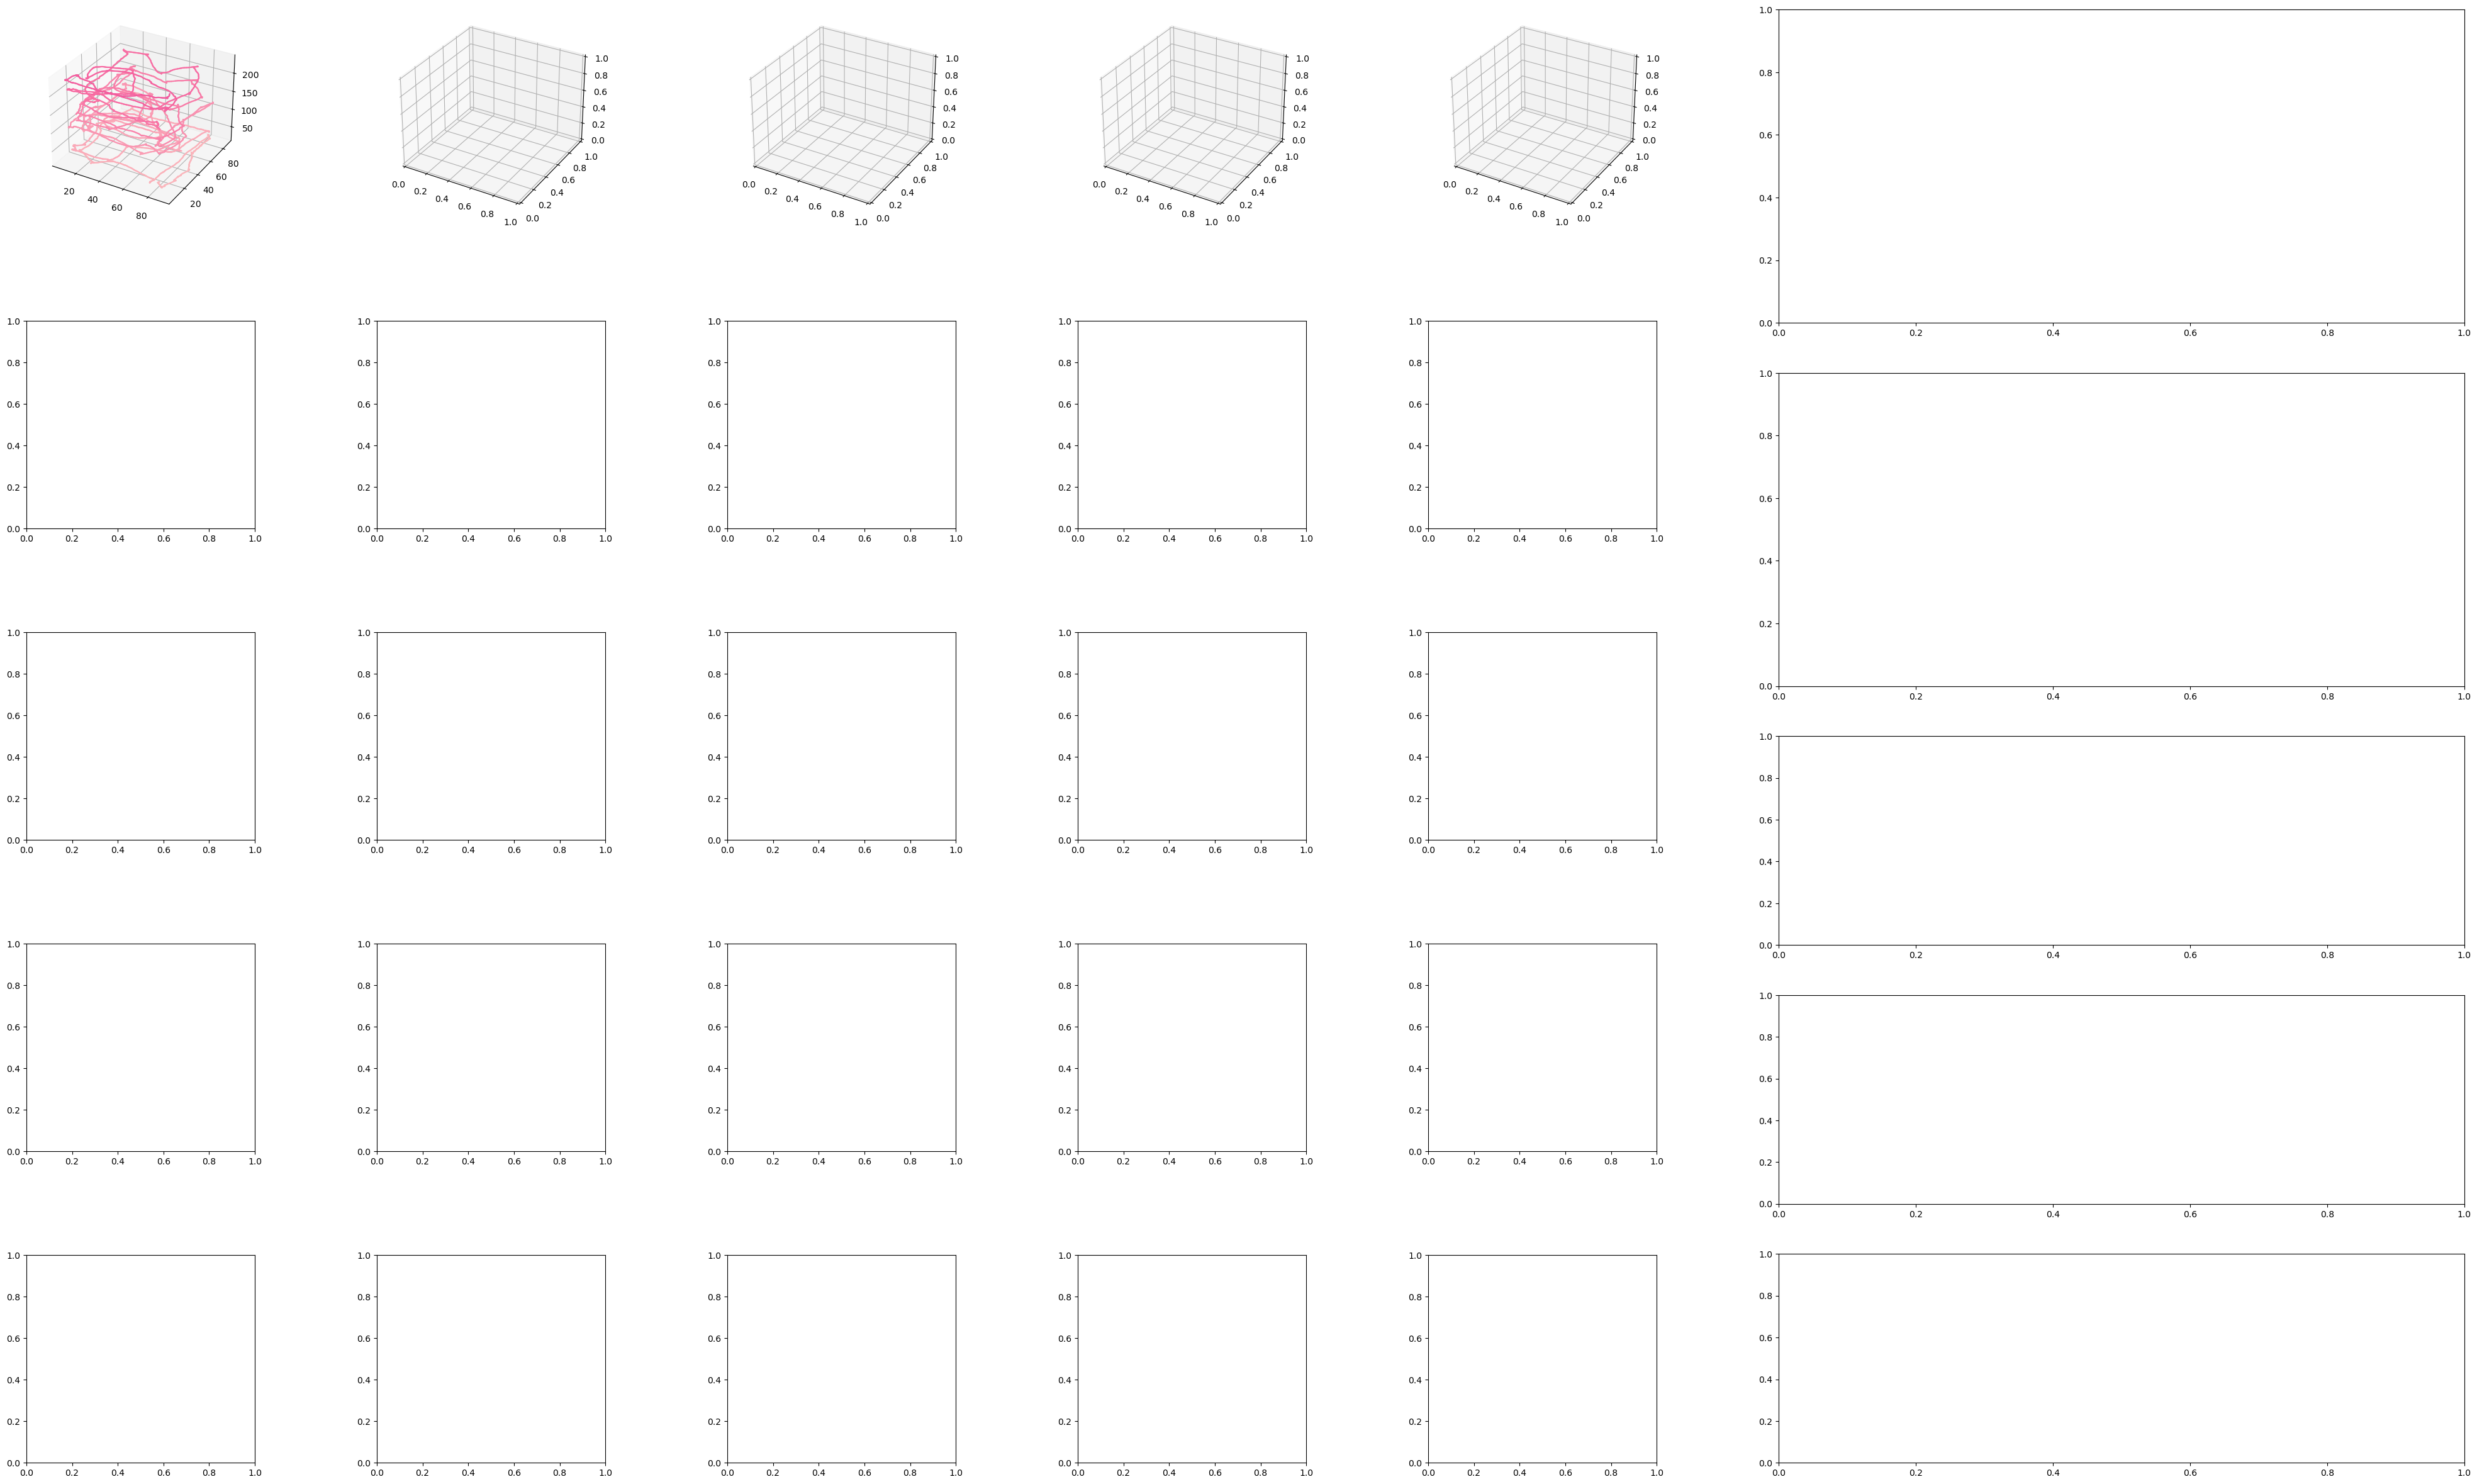

In [ ]:
# Big learning figure

example_mouse="MOU4562"
first_session = 0
second_session = 16
third_session = 17
fourth_session = 18
fifth_session = 19

# Création d'une figure principale avec une disposition 5x6 (5 lignes, 6 colonnes)
fig = plt.figure(figsize=(50, 30))  # Ajustez la taille totale
width_ratios = [6, 6, 6, 6, 6, 18]
gs = GridSpec(5, 6, figure=fig, wspace=0.4, hspace=0.5, width_ratios=width_ratios)  
# Ajustez `wspace` pour contrôler l'espace entre les colonnes
# Ajustez hspace pour contrôler l'espace entre les lignes

# Partie gauche : ancienne figure 1
axs = {}
for i in range(5):
    axs[(0, i)] = fig.add_subplot(gs[0, i], projection='3d')  # 3D plots

for row in range(1, 5):
    for col in range(5):
        axs[(row, col)] = fig.add_subplot(gs[row, col])  # 2D plots

# Partie droite : dernière colonne avec height_ratios spécifiques
height_ratios_last_column = [1.5, 1.5, 1, 1, 1]  # Ratios personnalisés
# Recalculer les ratios en fonction de la hauteur totale de la grille
normalized_ratios = [h / sum(height_ratios_last_column) for h in height_ratios_last_column]

# Créer des sous-grilles pour la dernière colonne
gs_last_column = GridSpecFromSubplotSpec(5, 1, subplot_spec=gs[:, 5], height_ratios=normalized_ratios)

# Ajouter des axes pour la dernière colonne
axs_right = []
for i in range(5):
    axs_right.append(fig.add_subplot(gs_last_column[i]))

# Ajout des tracés à gauche (figure 1)
# plot_trajectory_3d(axs[(0, 0)], example_mouse, first_session, X_positions_dict, Y_positions_dict, traject_time_dict)
# plot_trajectory_3d(axs[(0, 1)], example_mouse, second_session, X_positions_dict, Y_positions_dict, traject_time_dict, show_axes=False)
# plot_trajectory_3d(axs[(0, 2)], example_mouse, third_session, X_positions_dict, Y_positions_dict, traject_time_dict, show_axes=False)
# plot_trajectory_3d(axs[(0, 3)], example_mouse, fourth_session, X_positions_dict, Y_positions_dict, traject_time_dict, show_axes=False)
# plot_trajectory_3d(axs[(0, 4)], example_mouse, fifth_session, X_positions_dict, Y_positions_dict, traject_time_dict, show_axes=False)

# plot_run_trajectories(axs[(1, 0)], example_mouse, first_session, trapezes_coordinates_dict, good_turns_dict, X_positions_dict, Y_positions_dict, q=4)
# plot_run_trajectories(axs[(1, 1)], example_mouse, second_session, trapezes_coordinates_dict, good_turns_dict, X_positions_dict, Y_positions_dict, q=4)
# plot_run_trajectories(axs[(1, 2)], example_mouse, third_session, trapezes_coordinates_dict, good_turns_dict, X_positions_dict, Y_positions_dict, q=4)
# plot_run_trajectories(axs[(1, 3)], example_mouse, fourth_session, trapezes_coordinates_dict, good_turns_dict, X_positions_dict, Y_positions_dict, q=4)
# plot_run_trajectories(axs[(1, 4)], example_mouse, fifth_session, trapezes_coordinates_dict, good_turns_dict, X_positions_dict, Y_positions_dict, q=4)

# plot_trajectory_type_centered(axs[(2, 0)], example_mouse, first_session, X_positions_dict, Y_positions_dict, good_turns_dict, xlim=23, ylim=23, q=4, line_width=2.5, arrow_width=0.05)
# plot_trajectory_type_centered(axs[(2, 1)], example_mouse, second_session, X_positions_dict, Y_positions_dict, good_turns_dict, xlim=23, ylim=23, q=4, line_width=2.5, arrow_width=0.05)
# plot_trajectory_type_centered(axs[(2, 2)], example_mouse, third_session, X_positions_dict, Y_positions_dict, good_turns_dict, xlim=23, ylim=23, q=4, line_width=2.5, arrow_width=0.05)
# plot_trajectory_type_centered(axs[(2, 3)], example_mouse, fourth_session, X_positions_dict, Y_positions_dict, good_turns_dict, xlim=23, ylim=23, q=4, line_width=2.5, arrow_width=0.05)
# plot_trajectory_type_centered(axs[(2, 4)], example_mouse, fifth_session, X_positions_dict, Y_positions_dict, good_turns_dict, xlim=23, ylim=23, q=4, line_width=2.5, arrow_width=0.05)

# plot_cumulative_rewarded_unrewarded(axs[(3, 0)], example_mouse, first_session, runs_around_tower_dict, rewarded_direction_per_session)
# plot_cumulative_rewarded_unrewarded(axs[(3, 1)], example_mouse, second_session, runs_around_tower_dict, rewarded_direction_per_session, set_y_label=False, set_legend=False)
# plot_cumulative_rewarded_unrewarded(axs[(3, 2)], example_mouse, third_session, runs_around_tower_dict, rewarded_direction_per_session, set_y_label=False, set_legend=False)
# plot_cumulative_rewarded_unrewarded(axs[(3, 3)], example_mouse, fourth_session, runs_around_tower_dict, rewarded_direction_per_session, set_y_label=False, set_legend=False)
# plot_cumulative_rewarded_unrewarded(axs[(3, 4)], example_mouse, fifth_session, runs_around_tower_dict, rewarded_direction_per_session, set_y_label=False, set_legend=False)

# plot_speed_over_time(axs[(4, 0)], example_mouse, first_session, traject_time_dict, speeds_dict, good_turns_dict, xlim=1.7, set_title=False, title_type='run not defined', set_y_label=True)
# plot_speed_over_time(axs[(4, 1)], example_mouse, second_session, traject_time_dict, speeds_dict, good_turns_dict, xlim=1.7, set_title=False, title_type='run not defined', set_y_label=False)
# plot_speed_over_time(axs[(4, 2)], example_mouse, third_session, traject_time_dict, speeds_dict, good_turns_dict, xlim=1.7, set_title=False, title_type='run not defined', set_y_label=False)
# plot_speed_over_time(axs[(4, 3)], example_mouse, fourth_session, traject_time_dict, speeds_dict, good_turns_dict, xlim=1.7, set_title=False, title_type='run not defined', set_y_label=False)
# plot_speed_over_time(axs[(4, 4)], example_mouse, fifth_session, traject_time_dict, speeds_dict, good_turns_dict, xlim=1.7, set_title=False, title_type='run not defined', set_y_label=False)

# # Ajout des tracés à droite (figure 2)
# plot_flexibility_ratios(axs_right[0], ratio_CW_CCW_dict, groups_D1_D2, group_type="D1", show_legend=True)
# plot_flexibility_ratios(axs_right[1], ratio_CW_CCW_dict, groups_D1_D2, group_type="D2", show_legend=False)
# plot_metric_over_sessions_split(axs_right[2], example_mouse, total_QT_rewarded_dict, groups, colormaps, title=None, ylabel="Total nb of rewarded turns", show_legend=True)
# plot_metric_over_sessions_split(axs_right[3], example_mouse, meanspeed_QT_dict, groups, colormaps, title=None, ylabel="Mean speed of turns in rewarded direction")
# plot_metric_over_sessions_split(axs_right[4], example_mouse, total_QT_unrewarded_dict, groups, colormaps, title=None, ylabel="Total nb of unrewarded turns")

# Affichage
plt.show()


# Second part: CNO figures

In [48]:
# Extract necessary data for futures analysis
# need : rewarded_direction_per_session

success_percentage_dict = {}

for mouse in mice_list:
    success_percentage_dict[mouse] = {}

    # Parcourir chaque session de la souris
    for session_index, session_name in enumerate(session_list[mouse]):
        # Récupérer la direction récompensée de la session
        rewarded_direction = rewarded_direction_per_session[mouse].get(session_index, "both")
        
        # Récupérer les résultats pour CW et CCW
        total_CW = run_around_tower_results_dict[mouse][session_index]['All']['total_CW']
        total_CCW = run_around_tower_results_dict[mouse][session_index]['All']['total_CCW']
        
        # Calculer les pourcentages pour CW et CCW
        if total_CW + total_CCW > 0:  # Éviter la division par zéro
            percentage_CW = round((total_CW / (total_CW + total_CCW)) * 100, 2)
            percentage_CCW = round((total_CCW / (total_CW + total_CCW)) * 100, 2)
        else:
            percentage_CW = percentage_CCW = 0  # Si aucun run, pourcentage de succès est 0
            
        # Sélectionner le pourcentage en fonction de la direction récompensée
        if rewarded_direction == "both":
            success_percentage = percentage_rewarded_dict[mouse][session_index]
        elif rewarded_direction == "CW":
            success_percentage = percentage_CW
        elif rewarded_direction == "CCW":
            success_percentage = percentage_CCW
        else:
            print(f"No rewarded direction defined for session {session_index}")
            success_percentage = 0  # Cas par défaut si une valeur imprévue est présente

        # Ajouter au dictionnaire
        success_percentage_dict[mouse][session_index] = success_percentage

In [49]:
# Compare sessions by group (2 sessions, ctrl vs CNO)

gc.collect()

def compare_sessions_by_group(ax, data_dict, groups, session_indices, session_type="first", ylabel=None, ylim=None):
    """
    Compare les valeurs des sessions control et CNO pour chaque groupe sous forme de points reliés.
    
    Parameters:
    - ax: L'axe sur lequel le graphique sera tracé.
    - data_dict: Le dictionnaire contenant les données à comparer (e.g., total_distances).
    - groups: Dictionnaire des groupes de souris à analyser, avec le nom du groupe comme clé et la liste des souris comme valeur.
    - session_type: "first", "second" ou "third", la session à comparer (CNO et control).
    - ylabel: Label de l'axe Y pour le graphique.
    """
    # Extraire les indices de session pour le type de session spécifié
    control_session_index = session_indices.get(f"control_{session_type}")
    CNO_session_index = session_indices.get(f"CNO_{session_type}")
    
    if control_session_index is None or CNO_session_index is None:
        print(f"Erreur : indices de session manquants pour le type '{session_type}'.")
        return
    
    tick_positions = []
    session_labels = []
    group_annotations = []

    # Définir les colormaps pour chaque groupe

    colormaps = {
        "D1 DLS": "Greens",
        "D2 DLS": "Oranges",
        "D1 DMS": "Blues",
        "D2 DMS": "RdPu",
        "D1 dS": "Purples",
        "D2 dS": "OrRd",
        "D1": "GnBu",
        "D2": "YlOrBr",
        "All": "viridis"
    }

    # Déterminer les positions des sessions pour chaque groupe
    for i, (group_name, group_mice) in enumerate(groups.items()):
        group_control_data = []
        group_CNO_data = []
        
        # Extraire les données pour chaque souris du groupe
        for mouse in group_mice:
            if control_session_index in data_dict[mouse] and CNO_session_index in data_dict[mouse]:
                group_control_data.append(data_dict[mouse][control_session_index])
                group_CNO_data.append(data_dict[mouse][CNO_session_index])
            else:
                print(f"Avertissement : données manquantes pour {mouse} dans les sessions de type '{session_type}'")

        # Position des ticks pour le groupe (2 par groupe : "control" et "CNO")
        control_position = i * 2
        CNO_position = i * 2 + 1
        
        # Enregistrer les positions et labels pour chaque session
        tick_positions.extend([control_position, CNO_position])
        session_labels.extend(["Ctrl", "CNO"])
        
        # Ajouter une annotation pour le groupe centré entre control et CNO
        group_annotations.append((control_position + 0.5, group_name))  # Centre des positions control et CNO

        # Récupérer la colormap correspondante pour le groupe
        cmap = plt.get_cmap(colormaps.get(group_name))
        colors= cmap(np.linspace(0.3, 1, len(group_mice)))
        
        # Tracer les points pour chaque souris du groupe
        for j in range(len(group_control_data)):
            data = [group_control_data[j], group_CNO_data[j]]
            ax.plot([control_position, CNO_position], data, color=colors[j], linewidth=2, linestyle='-', marker='o', markersize=8)
    
    # Ajouter des titres et des labels
    # ax.set_title(f'{session_type.capitalize()} session', fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=11, fontweight='bold')

    # Définir les positions et labels des ticks sur l'axe X (pour chaque session)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(session_labels)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=11)

    # Limiter l'axe Y pour ajouter de la marge
    all_data = [value for group_mice in groups.values() for mouse in group_mice
                for value in [data_dict[mouse].get(control_session_index), data_dict[mouse].get(CNO_session_index)]
                if value is not None]
    ax.set_xlim(-0.5, len(groups) * 2 - 0.5)
    if ylim==None:
        ax.set_ylim(0, max(all_data) * 1.2)
    else:
        ax.set_ylim(ylim)

    # Ajouter les annotations pour les groupes sous chaque paire de ticks
    for pos, group_name in group_annotations:
        ax.annotate(group_name, xy=(pos, -0.1), xycoords=('data', 'axes fraction'), ha='center', 
                    fontsize=10, fontweight='bold')
    
    # Suppression des grilles pour un look plus propre
    ax.grid(False)
    
    # Améliorer la lisibilité des axes
    # ax.tick_params(axis='y', which='major', labelsize=10)
    # ax.tick_params(axis='x', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

# # Utiliser gridspec_kw pour ajuster l'espacement vertical
# fig, axs = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'hspace': 0.2})

# compare_sessions_by_group(axs[0], meanspeed_QT_dict, groups, session_indices, session_type="first",
#                           ylabel='Mean speed of runs around towers (cm/s)', ylim=(5,30))
# compare_sessions_by_group(axs[1], meanspeed_QT_dict, groups, session_indices, session_type="second",
#                           ylabel='Mean speed of runs around towers (cm/s)', ylim=(5,30))
# compare_sessions_by_group(axs[2], meanspeed_QT_dict, groups, session_indices, session_type="third",
#                           ylabel='Mean speed of runs around towers (cm/s)', ylim=(5,30))

# # plt.tight_layout()
# plt.show()

In [50]:
# Compare four sessions by groups

def compare_four_sessions_by_group(ax, data_dict, groups, session_indices, session_type="first", ylabel=None, ylim=(0,110)):
    """
    Compare les pourcentages de succès pour quatre sessions (control_AM, CNO_AM, control_PM, CNO_PM) pour chaque groupe.

    Parameters:
    - ax: L'axe sur lequel le graphique sera tracé.
    - success_percentage_dict: Dictionnaire contenant les pourcentages de succès pour chaque session.
    - groups: Dictionnaire des groupes de souris à analyser, avec le nom du groupe comme clé et la liste des souris comme valeur.
    - session_indices: Dictionnaire des indices de sessions.
    - session_type: "first", "second", ou "third" pour déterminer les sessions à comparer.
    - ylabel: Label de l'axe Y pour le graphique.
    - ylim: Limite pour l'axe Y.
    """
    # Extraire les indices de sessions AM
    control_AM_index = session_indices.get(f"control_{session_type}")
    CNO_AM_index = session_indices.get(f"CNO_{session_type}")

    if control_AM_index is None or CNO_AM_index is None:
        print(f"Erreur : indices de session manquants pour le type '{session_type}'.")
        return
    
    # Calculer les indices pour PM en ajoutant 1 aux indices AM
    control_PM_index = control_AM_index + 1
    CNO_PM_index = CNO_AM_index + 1

    # Mapping entre noms internes et labels affichés
    session_mapping = {
        "control_AM": "Ctrl AM",
        "control_PM": "Ctrl PM",
        "CNO_AM": "CNO AM",
        "CNO_PM": "CNO PM"
    }

    internal_keys = ["control_AM", "control_PM", "CNO_AM", "CNO_PM"]
    session_labels = [session_mapping[key] for key in internal_keys]

    tick_positions = []
    group_annotations = []
    
    # # Labels pour les quatre sessions
    # session_labels = ["control AM", "control PM", "CNO AM", "CNO PM"]
    # tick_positions = []
    # group_annotations = []

    # Définir les colormaps pour chaque groupe
    colormaps = {
        "D1 DLS": "Greens",
        "D2 DLS": "Oranges",
        "D1 DMS": "Blues",
        "D2 DMS": "RdPu",
        "D1 dS": "Purples",
        "D2 dS": "OrRd",
        "D1": "GnBu",
        "D2": "YlOrBr",
        "All": "viridis"
    }
    
    # Parcourir chaque groupe pour extraire et tracer les données
    for i, (group_name, group_mice) in enumerate(groups.items()):
        group_session_data = {key: [] for key in internal_keys}  # Conteneur pour les données des sessions du groupe
        
        # Extraire les données pour chaque souris du groupe
        for mouse in group_mice:
            # Vérifier la disponibilité des données pour chaque session
            if control_AM_index in data_dict[mouse] and \
               CNO_AM_index in data_dict[mouse] and \
               control_PM_index in data_dict[mouse] and \
               CNO_PM_index in data_dict[mouse]:

                # Ajouter les données de chaque session pour la souris
                group_session_data["control_AM"].append(data_dict[mouse][control_AM_index])
                group_session_data["CNO_AM"].append(data_dict[mouse][CNO_AM_index])
                group_session_data["control_PM"].append(data_dict[mouse][control_PM_index])
                group_session_data["CNO_PM"].append(data_dict[mouse][CNO_PM_index])
            else:
                print(f"Avertissement : données manquantes pour {mouse} dans les sessions de type '{session_type}'")

        # Position des ticks pour le groupe (4 par groupe : control_AM, CNO_AM, control_PM, CNO_PM)
        base_position = i * 4
        for j, key in enumerate(internal_keys):
            tick_positions.append(base_position + j)

        # Ajouter une annotation pour le groupe centré entre les positions des sessions
        group_annotations.append((base_position + 1.5, group_name))  # Centre des quatre sessions
        
        # Récupérer la colormap pour le groupe
        cmap = plt.get_cmap(colormaps.get(group_name))
        colors = cmap(np.linspace(0.3, 1, len(group_mice)))

        # Tracer les points pour chaque souris dans le groupe
        for j in range(len(group_session_data["control_AM"])):
            data = [
                group_session_data["control_AM"][j],
                group_session_data["control_PM"][j],
                group_session_data["CNO_AM"][j],
                group_session_data["CNO_PM"][j]
            ]
            ax.plot(range(base_position, base_position + 4), data, color=colors[j], linewidth=2, linestyle='-', marker='o', markersize=8)
    
    # Ajouter des titres et des labels
    # ax.set_title(f'{session_type.capitalize()} session', fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=11, fontweight='bold')

    # Définir les positions et labels des ticks sur l'axe X pour chaque session
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(session_labels * len(groups))  # Répéter les labels pour chaque groupe
    
    # Limiter l'axe Y pour ajouter de la marge
    all_data = [value for group_mice in groups.values() for mouse in group_mice
                for value in [data_dict[mouse].get(control_AM_index),
                              data_dict[mouse].get(CNO_AM_index),
                              data_dict[mouse].get(control_PM_index),
                              data_dict[mouse].get(CNO_PM_index)]
                if value is not None]
    ax.set_xlim(-0.5, len(groups) * 4 - 0.5)
    if ylim is None:
        ax.set_ylim(0, max(all_data) * 1.2)
    else:
        ax.set_ylim(ylim)

    # Ajouter les annotations pour les groupes sous chaque bloc de ticks
    for pos, group_name in group_annotations:
        ax.annotate(group_name, xy=(pos, -0.1), xycoords=('data', 'axes fraction'), ha='center', 
                    fontsize=10, fontweight='bold')

    # Suppression des grilles pour un look plus propre
    ax.grid(False)

    # Améliorer la lisibilité des axes
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='x', labelsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

# Utilisation de la fonction pour tracer les résultats
# fig, axs = plt.subplots(1, 1, figsize=(16, 6))
# compare_four_sessions_by_group(axs, success_percentage_dict, groups, session_indices, session_type="first", ylabel='Percentage of turns in rewarded direction (%)')

In [51]:
# Figure de comparaison D1/D2

# def plot_stats_AM_PM(ax, data_dict, groups, session_indices, group_type="D1 DLS", session_type="first", ylabel=None, ylim=(0, 110)):
#     """
#     Plot les comparaisons entre plusieurs sessions avec les données AM et PM et des calculs spécifiques.

#     Parameters:
#     - ax: L'axe sur lequel le graphique sera tracé.
#     - data_dict: Dictionnaire contenant les données pour chaque session.
#     - groups: Dictionnaire des groupes de souris à analyser.
#     - group_type: Le type de groupe (ex: "D1 DLS", "D2 DLS", etc.) à analyser.
#     - session_indices: Dictionnaire des indices de sessions.
#     - session_type: "first", "second", ou "third" pour déterminer les sessions à comparer.
#     - ylabel: Label de l'axe Y pour le graphique.
#     - ylim: Limite pour l'axe Y.
#     """
#     # Extraire les indices de sessions pour chaque cas
#     if session_type == "third":
#         J_minus_1_AM_index = session_indices.get(f"control_{session_type}")
#         J_minus_1_PM_index = J_minus_1_AM_index + 1
#         J_0_AM_index = session_indices.get(f"CNO_{session_type}")
#         J_0_PM_index = J_0_AM_index + 1

#         if J_minus_1_AM_index is None or J_0_AM_index is None:
#             print(f"Erreur : indices de session manquants pour le type '{session_type}'.")
#             return
#     else:
#         J_minus_2_AM_index = session_indices.get(f"control_{session_type}")
#         J_minus_2_PM_index = J_minus_2_AM_index + 1
#         J_minus_1_AM_index = J_minus_2_PM_index + 1
#         J_minus_1_PM_index = J_minus_1_AM_index + 1
#         J_0_AM_index = session_indices.get(f"CNO_{session_type}")
#         J_0_PM_index = J_0_AM_index + 1

#         if J_minus_2_AM_index is None or J_0_AM_index is None:
#             print(f"Erreur : indices de session manquants pour le type '{session_type}'.")
#             return

#     # Couleur basée sur le type de groupe
#     colormaps = {
#         "D1 DLS": "Greens",
#         "D2 DLS": "Oranges",
#         "D1 DMS": "Blues",
#         "D2 DMS": "RdPu",
#         "D1 dS": "Purples",
#         "D2 dS": "OrRd",
#         "D1": "GnBu",
#         "D2": "YlOrBr",
#         "All": "viridis"
#     }

#     cmap = plt.get_cmap(colormaps.get(group_type))
#     colors = cmap(np.linspace(0, 0.95, len(groups[group_type])))

#     # Extraction et tracé des données
#     base_position = 0
#     for mouse_idx, mouse in enumerate(groups[group_type]):
#         # Vérifier la disponibilité des données
#         if all(index in data_dict[mouse] for index in 
#                [J_minus_1_AM_index, J_minus_1_PM_index, J_0_AM_index, J_0_PM_index]):
#             # Comparaison AM
#             AM_data = [data_dict[mouse].get(J_minus_1_AM_index), data_dict[mouse].get(J_0_AM_index)]
#             ax.plot(range(base_position, base_position + 2), AM_data, color=colors[mouse_idx], linestyle='-', marker='o', linewidth=2, markersize=8)

#             # Comparaison PM
#             PM_data = [data_dict[mouse].get(J_minus_1_PM_index), data_dict[mouse].get(J_0_PM_index)]
#             ax.plot(range(base_position + 2, base_position + 4), PM_data, color=colors[mouse_idx], linestyle='-', marker='o', linewidth=2, markersize=8)

#             # Comparaison PM-AM
#             if session_type == "third":
#                 PM_AM_diffs = [
#                     data_dict[mouse].get(J_minus_1_PM_index) - data_dict[mouse].get(J_minus_1_AM_index),
#                     data_dict[mouse].get(J_0_PM_index) - data_dict[mouse].get(J_0_AM_index)
#                 ]
#                 ax.plot(range(base_position + 4, base_position + 6), PM_AM_diffs, color=colors[mouse_idx], linestyle='-', marker='o', linewidth=2, markersize=8)
#             else:
#                 PM_AM_diffs = [
#                     data_dict[mouse].get(J_minus_2_PM_index) - data_dict[mouse].get(J_minus_2_AM_index),
#                     data_dict[mouse].get(J_minus_1_PM_index) - data_dict[mouse].get(J_minus_1_AM_index),
#                     data_dict[mouse].get(J_0_PM_index) - data_dict[mouse].get(J_0_AM_index)
#                 ]
#                 ax.plot(range(base_position + 4, base_position + 7), PM_AM_diffs, color=colors[mouse_idx], linestyle='-', marker='o', linewidth=2, markersize=8)
#         else:
#             print(f"Avertissement : données manquantes pour {mouse} dans les sessions de type '{session_type}'")

#     # Définir les ticks et labels dynamiquement
#     if session_type == "third":
#         tick_positions = [0, 1, 2, 3, 4, 5]
#         tick_labels = [
#             "AM\nDay-1", "AM\nDay-0",
#             "PM\nDay-1", "PM\nDay-0",
#             "PM-AM\nDay-1", "PM-AM\nDay-0"
#         ]
#     else:
#         tick_positions = [0, 1, 2, 3, 4, 5, 6]
#         tick_labels = [
#             "AM\nDay-2", "AM\nDay-0",
#             "PM\nDay-2", "PM\nDay-0",
#             "PM-AM\nDay-2", "PM-AM\nDay-1", "PM-AM\nDay-0"
#         ]

#     # Ajouter des titres et des labels
#     ax.set_title(f'{group_type}', fontsize=14, fontweight='bold')
#     ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')

#     # Définir les positions et labels des ticks sur l'axe X
#     ax.set_xticks(tick_positions)
#     ax.set_xticklabels(tick_labels)

#     # Limiter l'axe Y pour ajouter de la marge
#     all_data = [value for mouse in groups[group_type]
#                 for value in [
#                     data_dict[mouse].get(J_minus_2_AM_index) if session_type != "third" else None,
#                     data_dict[mouse].get(J_minus_1_AM_index), data_dict[mouse].get(J_0_AM_index),
#                     data_dict[mouse].get(J_minus_2_PM_index) if session_type != "third" else None,
#                     data_dict[mouse].get(J_minus_1_PM_index), data_dict[mouse].get(J_0_PM_index)]
#                 if value is not None]

#     ax.set_xlim(-0.5, len(tick_positions) - 0.5)
#     if ylim is None:
#         ax.set_ylim(0, max(all_data) * 1.2)
#     else:
#         ax.set_ylim(ylim)

#     # Suppression des grilles pour un look plus propre
#     ax.grid(False)

#     # Améliorer la lisibilité des axes
#     ax.tick_params(axis='y', which='major', labelsize=10)
#     ax.tick_params(axis='x', which='major', labelsize=8)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_linewidth(1.5)
#     ax.spines['bottom'].set_linewidth(1.5)

# # fig, axs = plt.subplots(1, 2, figsize=(24, 8))

# plot_stats_AM_PM(axs[0], success_percentage_dict, groups_D1_D2, session_indices, group_type="D1", session_type="third", ylabel='Percentage of turns in rewarded direction (%)', ylim=(-30, 110))
# plot_stats_AM_PM(axs[1], success_percentage_dict, groups_D1_D2, session_indices, group_type="D2", session_type="third", ylabel=None, ylim=(-30, 110))

In [52]:
# Plot median ang speed of BT (for D1/D2 only)

# fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# compare_sessions_by_group(axs[0], median_angular_speed_BT, groups_D1_D2, session_indices, session_type="first",
#                           ylabel='Mean speed of runs around towers (cm/s)', ylim=(-110,110))
# compare_sessions_by_group(axs[1], median_angular_speed_BT, groups_D1_D2, session_indices, session_type="second",
#                           ylabel=None, ylim=(-110,110))
# compare_sessions_by_group(axs[2], median_angular_speed_BT, groups_D1_D2, session_indices, session_type="third",
#                           ylabel=None, ylim=(-110,110))

# # plt.tight_layout()
# plt.show()

In [53]:
# Figure de correlation D1/D2

def plot_correlation_angular_speed_success(ax, angular_speed_dict, success_dict, groups, session_indices=None,
                                           session_index=None, group_type="D1 DLS", session_type="first", show_ylabel=True):
    """
    Plot une corrélation entre la médiane des vitesses angulaires et les pourcentages de succès pour une session donnée.

    Parameters:
    - ax: L'axe sur lequel le graphique sera tracé.
    - angular_speed_dict: Dictionnaire des vitesses angulaires médianes pour chaque session.
    - success_dict: Dictionnaire des pourcentages de succès pour chaque session.
    - groups: Dictionnaire des groupes de souris.
    - session_indices: (Optionnel) Dictionnaire des indices de sessions.
    - session_index: (Optionnel) Index de session à analyser directement.
    - group_type: Le type de groupe à analyser.
    - session_type: (Optionnel) Type de session ("first", "second", "third"). Utilisé si `session_index` n'est pas fourni.
    """
    # Vérifier si un index de session est donné
    if session_index is not None:
        # Utiliser directement l'index fourni
        selected_session_index = session_index
    else:
        # Vérifier que session_indices et session_type sont valides
        if session_indices is None:
            print("Erreur : 'session_indices' doit être fourni si 'session_index' n'est pas spécifié.")
            return
        selected_session_index = session_indices.get(f"CNO_{session_type}")
        if selected_session_index is None:
            print(f"Erreur : indice de session introuvable pour le type '{session_type}'.")
            return
    
    # Préparer les données pour la corrélation
    angular_speeds = []
    success_percentages = []
    mice = groups[group_type]

    for mouse in mice:
        # Récupérer les données pour la session donnée
        angular_speed = angular_speed_dict[mouse].get(selected_session_index)
        success_percentage = success_dict[mouse].get(selected_session_index)

        # Vérifier si les deux données sont disponibles
        if angular_speed is not None and success_percentage is not None:
            angular_speeds.append(angular_speed)
            success_percentages.append(success_percentage)

    # Vérifier qu'il y a des données pour effectuer la corrélation
    if not angular_speeds or not success_percentages:
        print(f"Pas de données disponibles pour la corrélation dans le groupe '{group_type}' pour l'index de session {selected_session_index}.")
        return
    
    # Calcul de la corrélation (Pearson)
    correlation_coefficient = np.corrcoef(angular_speeds, success_percentages)[0, 1]

    if group_type == 'D2':
        color_line = 'darkorange'
        color_points = 'saddlebrown'
    else: 
        color_line = 'dodgerblue'
        color_points = 'darkblue'
    
    # Tracé du nuage de points
    ax.scatter(angular_speeds, success_percentages, color=color_points, alpha=0.7)

    # Ajustement d'une régression linéaire
    slope, intercept = np.polyfit(angular_speeds, success_percentages, 1)
    regression_line = np.polyval([slope, intercept], angular_speeds)
    ax.plot(angular_speeds, regression_line, color=color_line, linestyle="-", label=f"r={correlation_coefficient:.2f}")

    # Titres et labels
    # ax.set_title(f"Correlation {group_type}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Median of angular speed (degree/s)", fontsize=12, fontweight='bold')
    if show_ylabel:
        ax.set_ylabel("Choice accuracy (%)", fontsize=12, fontweight='bold')
    ax.legend(loc="upper left", fontsize=12)

    # Amélioration de l'apparence
    # ax.grid(True, linestyle="--", alpha=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# plot_correlation_angular_speed_success(axs[0], median_angular_speed_BT, success_percentage_dict, groups_D1_D2, session_indices, session_index=42, group_type="D1", session_type="first")
# plot_correlation_angular_speed_success(axs[1], median_angular_speed_BT, success_percentage_dict, groups_D1_D2, session_indices, session_index=42, group_type="D2", session_type="first", show_ylabel=False)

# plt.tight_layout()
# plt.show()

In [54]:
# # Plot correlation between choice accuracy and median angular speed of BT
# # Merge sessions together, keep the D1/D2 dichotomy

# def plot_correlation_angular_speed_success_multiple_sessions(
#     ax, angular_speed_dict, success_dict, groups, session_indexes=None, 
#     group_type="D1 DLS"):
#     """
#     Plot une corrélation entre la médiane des vitesses angulaires et les pourcentages de succès
#     pour plusieurs sessions données.

#     Parameters:
#     - ax: L'axe sur lequel le graphique sera tracé.
#     - angular_speed_dict: Dictionnaire des vitesses angulaires médianes pour chaque session.
#     - success_dict: Dictionnaire des pourcentages de succès pour chaque session.
#     - groups: Dictionnaire des groupes de souris.
#     - session_indices: (Optionnel) Dictionnaire des indices de sessions.
#     - session_indexes: Liste des indices de sessions à analyser.
#     - group_type: Le type de groupe à analyser.
#     """
#     if session_indexes is None:
#         print("Erreur : Vous devez fournir une liste d'indices de sessions via 'session_indexes'.")
#         return

#     # Initialisation des listes pour les données combinées
#     angular_speeds = []
#     success_percentages = []
#     mice = groups[group_type]

#     for mouse in mice:
#         for session_index in session_indexes:
#             # Récupérer les données pour la session donnée
#             angular_speed = angular_speed_dict[mouse].get(session_index)
#             success_percentage = success_dict[mouse].get(session_index)

#             # Vérifier si les deux données sont disponibles
#             if angular_speed is not None and success_percentage is not None:
#                 angular_speeds.append(angular_speed)
#                 success_percentages.append(success_percentage)

#     # Vérifier qu'il y a des données pour effectuer la corrélation
#     if not angular_speeds or not success_percentages:
#         print(f"Pas de données disponibles pour la corrélation dans le groupe '{group_type}' pour les sessions {session_indexes}.")
#         return

#     # Calcul de la corrélation (Pearson)
#     correlation_coefficient = np.corrcoef(angular_speeds, success_percentages)[0, 1]

#     if group_type == 'D2':
#         color_line = 'darkorange'
#         color_points = 'saddlebrown'
#     else: 
#         color_line = 'dodgerblue'
#         color_points = 'darkblue'

#     # Tracé du nuage de points
#     ax.scatter(angular_speeds, success_percentages, color=color_points, alpha=0.7, label=f"r={correlation_coefficient:.2f}")

#     # Ajustement d'une régression linéaire
#     slope, intercept = np.polyfit(angular_speeds, success_percentages, 1)
#     regression_line = np.polyval([slope, intercept], angular_speeds)
#     ax.plot(angular_speeds, regression_line, color=color_line, linestyle="-", label="Linear regression")

#     # Titres et labels
#     ax.set_title(f"Correlation {group_type}", fontsize=14, fontweight="bold")
#     ax.set_xlabel("Median of angular speed (degree/s)", fontsize=12)
#     ax.set_ylabel("Choice accuracy (%)", fontsize=12)
#     ax.legend(fontsize=10)

#     # Amélioration de l'apparence
#     # ax.grid(True, linestyle="--", alpha=0.5)
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)

# CNO_sessions_indexes = [20,30,42]

# fig, axs = plt.subplots(1,2,figsize=(16, 6))

# plot_correlation_angular_speed_success_multiple_sessions(
#     axs[0], median_angular_speed_BT, success_percentage_dict, groups_D1_D2, session_indexes=CNO_sessions_indexes, 
#     group_type="D1")
# plot_correlation_angular_speed_success_multiple_sessions(
#     axs[1], median_angular_speed_BT, success_percentage_dict, groups_D1_D2, session_indexes=CNO_sessions_indexes, 
#     group_type="D2")

# plt.show()

/tmp/ipykernel_23597/223190450.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


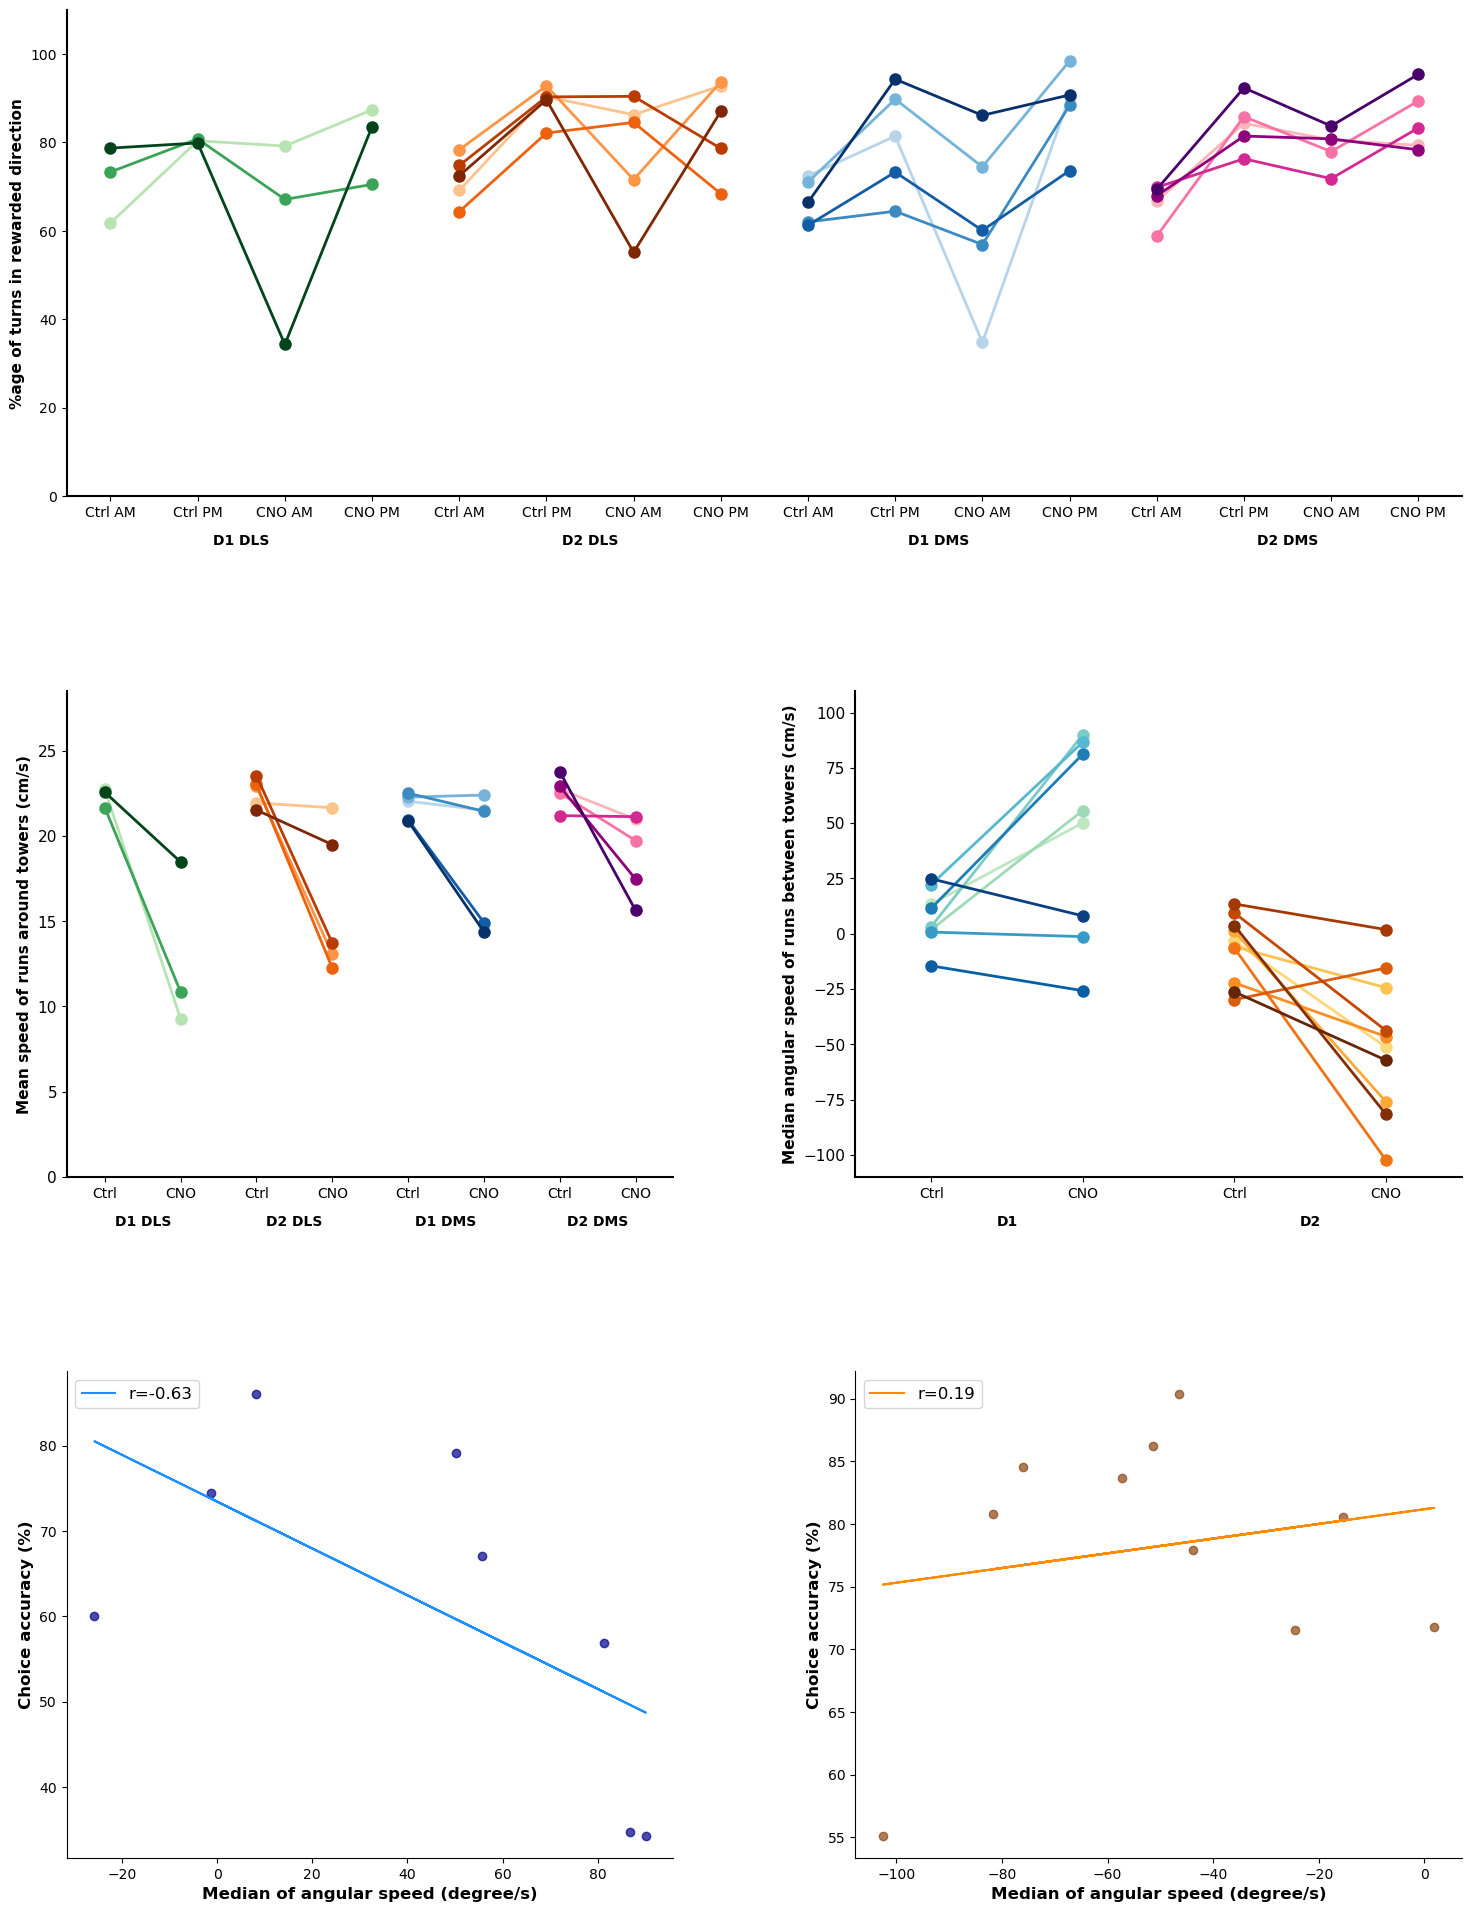

In [57]:
# CNO figure
# Make a big figure to be sure to respect scales

# Paramètres globaux
injection = "first"
session_index = 20

# Création de la figure principale
fig = plt.figure(figsize=(18, 24))  # Largeur=18, Hauteur=6*4=24

# Création du GridSpec principal
outer_grid = GridSpec(3, 2, height_ratios=[6, 6, 6], width_ratios=[1, 1], figure=fig, hspace=0.4, wspace=0.3)

# Ligne 1 : graphique sur 2 colonnes
axs1 = fig.add_subplot(outer_grid[0, :])  # Ligne entière (colonnes 0 et 1 combinées)
compare_four_sessions_by_group(axs1, success_percentage_dict, groups, session_indices, session_type=injection,
                               ylabel='%age of turns in rewarded direction')

# Ligne 2 : 2 graphiques (gauche et droite)
axs2_left = fig.add_subplot(outer_grid[1, 0])  # Graphique à gauche
compare_sessions_by_group(axs2_left, meanspeed_QT_dict, groups, session_indices, session_type=injection,
                          ylabel='Mean speed of runs around towers (cm/s)')

axs2_right = fig.add_subplot(outer_grid[1, 1])  # Graphique à droite
compare_sessions_by_group(axs2_right, median_angular_speed_BT, groups_D1_D2, session_indices, session_type=injection,
                          ylabel='Median angular speed of runs between towers (cm/s)', ylim=(-110, 110))

# Ligne 3 : 2 graphiques (gauche et droite)
axs3_left = fig.add_subplot(outer_grid[2, 0])  # Graphique à gauche
plot_correlation_angular_speed_success(axs3_left, median_angular_speed_BT, success_percentage_dict, groups_D1_D2,
                                       session_indices, session_index=session_index, group_type="D1", session_type=injection)

axs3_right = fig.add_subplot(outer_grid[2, 1])  # Graphique à droite
plot_correlation_angular_speed_success(axs3_right, median_angular_speed_BT, success_percentage_dict, groups_D1_D2,
                                       session_indices, session_index=session_index, group_type="D2", session_type=injection)

# Affichage de la figure
plt.tight_layout()
plt.show()
